In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from os import mkdir
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from b2b_regression import *
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from mouse_utils import *

## Load data & convert to csv

In [2]:
mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M01.mat")["mouse_struct"]
column_names = np.stack(([mouse_struct[i][0] for i in range(0, (len(mouse_struct)))]))
data_type = mouse_struct[0].dtype
column_names = np.asarray(data_type.names)

In [3]:
mice = ["01", "02", "03", "04", "05", "06"]

In [4]:
n_neurons = []
for mouse in mice:
    session_labels = ["T1", "T2", "T3", "T4", "T5",  "T6", "T7", "T8"]
    mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M%s.mat" % mouse)["mouse_struct"]
    directoryExists = os.path.exists("Rule-switch experiment/csv/mouse%s" % mouse)
    if not directoryExists:
        mkdir("Rule-switch experiment/csv/mouse%s" % mouse)
    if mouse == "01" or mouse == "02":
        session_labels.remove("T3")
    elif mouse == "06":
        session_labels.remove("T7")
        session_labels.remove("T8")
    for session in session_labels:
        for i in range(len(mouse_struct[0][session_labels.index(session)])):
            if len(mouse_struct[0][session_labels.index(session)][i]) == 0:
                df = pd.DataFrame(columns = [column_names[i]])
                df.to_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column_names[i]))
            else:
                try:
                    df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][i][0], columns = [column_names[i]])
                except Exception as e:
                    pass
                df["mouse"] = mouse
                df["session"] = session
                df.to_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column_names[i]))
        is_mouse_no_T3 = False
        neuron_id = np.empty([len(mouse_struct[0][session_labels.index(session)][7]),], dtype = "U2")
        neuron_id = ["n%s" % neuron for neuron in np.arange(len(mouse_struct[0][session_labels.index(session)][7]))]
        df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][7].T, columns = neuron_id)
        if neuron_id not in n_neurons:
            n_neurons.append(neuron_id)
        df.to_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session,column_names[7]))

In [5]:
data_list_wide = []
data_list_long = []
i = 0
for mouse in mice:
    mouse_list = []
    for session in session_labels:
        try:
            df = pd.read_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_CategoryID.csv" % (mouse, mouse, session)).iloc[:, 1:]
            for column in np.delete(column_names, [0,7, 8, 9, 10,11]):
                df_to_merge = pd.read_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column)).iloc[:, 1]
                df = pd.concat([df, df_to_merge], axis = 1)
            df_to_merge = pd.read_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column_names[7]))
            df_mouse_session = pd.concat([df, df_to_merge.iloc[:, 1:]], axis = 1)
            mouse_list.append(df_mouse_session)
        except FileNotFoundError as e:
            pass
    df_mouse_wide = pd.concat(mouse_list, axis = 0)
    data_list_wide.append(df_mouse_wide)
    df_mouse_long = df_mouse_wide.melt(id_vars=np.asarray(df.columns[:9]), value_vars =n_neurons[i], var_name = "Cell", value_name = "CellResponse", ignore_index= True)
    data_list_long.append(df_mouse_long)
    i = i + 1
data_wide = pd.concat(data_list_wide, axis = 0)
data_long = pd.concat(data_list_long, axis = 0)
data_long = data_long.rename(columns = {"stimulusSF":"StimulusSF"})
data_long["CategoryID"] = data_long["CategoryID"].replace(1, 0)
data_long["CategoryID"] = data_long["CategoryID"].replace(5, 1)

In [6]:
mice_diff_regions = ["07", "08", "09", "10", "11"]
session_labels = ["T1", "T2", "T3", "T4", "T5",  "T6", "T7", "T8"]
n_neurons_region1 = []
directoryExists = os.path.exists("Rule-switch experiment/csv/region1")
if not directoryExists:
    mkdir("Rule-switch experiment/csv/region1")
for mouse in mice_diff_regions:
    mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M%s_Region1.mat" % mouse)["mouse_struct"]
    directoryExists = os.path.exists("Rule-switch experiment/csv/region1/mouse%s_region1" % mouse)
    if not directoryExists:
        mkdir("Rule-switch experiment/csv/region1/mouse%s_region1" % mouse)
    for session in session_labels:
        for i in range(len(mouse_struct[0][session_labels.index(session)])):
            if len(mouse_struct[0][session_labels.index(session)][i]) == 0:
                df = pd.DataFrame(columns = [column_names[i]])
                df.to_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column_names[i]))
            else:
                try:
                    df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][i][0], columns = [column_names[i]])
                except Exception as e:
                    pass
                df["mouse"] = mouse
                df["session"] = session
                df.to_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column_names[i]))
        neuron_id = np.empty([len(mouse_struct[0][session_labels.index(session)][7]),], dtype = "U2")
        neuron_id = ["n%s" % neuron for neuron in np.arange(len(mouse_struct[0][session_labels.index(session)][7]))]
        df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][7].T, columns = neuron_id)
        if neuron_id not in n_neurons_region1:
            n_neurons_region1.append(neuron_id)
        df.to_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session,column_names[7]))

In [7]:
data_list_region1 = []
i = 0
for mouse in mice_diff_regions:
    mouse_list = []
    for session in session_labels:
        try:
            df = pd.read_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_CategoryID_region1.csv" % (mouse, mouse, session)).iloc[:, 1:]
            for column in np.delete(column_names, [0,7, 8, 9, 10,11]):
                df_to_merge = pd.read_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column)).iloc[:, 1]
                df = pd.concat([df, df_to_merge], axis = 1)
            df_to_merge = pd.read_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column_names[7]))
            df_mouse_session = pd.concat([df, df_to_merge.iloc[:, 1:]], axis = 1)
            mouse_list.append(df_mouse_session)
        except FileNotFoundError as e:
            pass

    df_mouse = pd.concat(mouse_list, axis = 0)
    df_mouse = df_mouse.melt(id_vars=np.asarray(df.columns[:9]), value_vars =n_neurons_region1[i], var_name = "Cell", value_name = "CellResponse", ignore_index= True)
    data_list_region1.append(df_mouse)
    i = i + 1
data_region1 = pd.concat(data_list_region1, axis = 0)
data_region1 = data_region1.rename(columns = {"stimulusSF":"StimulusSF"})
data_region1["CategoryID"] = data_region1["CategoryID"].replace(1, 0)
data_region1["CategoryID"] = data_region1["CategoryID"].replace(5, 1)

In [8]:
n_neurons_region2 = []
directoryExists = os.path.exists("Rule-switch experiment/csv/region2")
if not directoryExists:
    mkdir("Rule-switch experiment/csv/region2")
for mouse in mice_diff_regions:
    mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M%s_Region2.mat" % mouse)["mouse_struct"]
    directoryExists = os.path.exists("Rule-switch experiment/csv/region2/mouse%s_region2" % mouse)
    if not directoryExists:
        mkdir("Rule-switch experiment/csv/region2/mouse%s_region2" % mouse)
    for session in session_labels:
        for i in range(len(mouse_struct[0][session_labels.index(session)])):
            if len(mouse_struct[0][session_labels.index(session)][i]) == 0:
                df = pd.DataFrame(columns = [column_names[i]])
                df.to_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column_names[i]))
            else:
                try:
                    df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][i][0], columns = [column_names[i]])
                except Exception as e:
                    pass
                df["mouse"] = mouse
                df["session"] = session
                df.to_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column_names[i]))
        neuron_id = np.empty([len(mouse_struct[0][session_labels.index(session)][7]),], dtype = "U2")
        neuron_id = ["n%s" % neuron for neuron in np.arange(len(mouse_struct[0][session_labels.index(session)][7]))]
        df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][7].T, columns = neuron_id)
        if neuron_id not in n_neurons_region2:
            n_neurons_region2.append(neuron_id)
        df.to_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session,column_names[7]))

In [9]:
data_list_region2 = []
i = 0
for mouse in mice_diff_regions:
    mouse_list = []
    for session in session_labels:
        try:
            df = pd.read_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_CategoryID_region2.csv" % (mouse, mouse, session)).iloc[:, 1:]
            for column in np.delete(column_names, [0,7, 8, 9, 10,11]):
                df_to_merge = pd.read_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column)).iloc[:, 1]
                df = pd.concat([df, df_to_merge], axis = 1)
            df_to_merge = pd.read_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column_names[7]))
            df_mouse_session = pd.concat([df, df_to_merge.iloc[:, 1:]], axis = 1)
            mouse_list.append(df_mouse_session)
        except FileNotFoundError as e:
            pass
    df_mouse = pd.concat(mouse_list, axis = 0)
    df_mouse = df_mouse.melt(id_vars=np.asarray(df.columns[:9]), value_vars =n_neurons_region2[i], var_name = "Cell", value_name = "CellResponse", ignore_index= True)
    data_list_region2.append(df_mouse)
    i = i + 1
data_region2 = pd.concat(data_list_region2, axis = 0)
data_region2 = data_region2.rename(columns = {"stimulusSF":"StimulusSF"})
data_region2["CategoryID"] = data_region2["CategoryID"].replace(1, 0)
data_region2["CategoryID"] = data_region2["CategoryID"].replace(5, 1)

## Prepare data for the analysis

In [29]:
rules = {
            "1":"ORI",
            "2":"SF",
            "3":"SF",
            "4":"ORI",
            "5":"SF",
            "6":"SF"
        }

rules_region = {
            "7":"SF",
            "8":"ORI",
            "9":"ORI",
            "10":"SF",
            "11":"ORI",
        }
        
rule_feature_map = {
    "ORI":"StimulusORI",
    "SF":"StimulusSF"
}

In [11]:
data_long_mouse1_T5 = data_long[(data_long["mouse"] == 1) & (data_long["session"] == "T5")]
data_long_mouse1_T5 = pd.get_dummies(data_long_mouse1_T5, columns=['StimulusSF', "StimulusORI"])
data_long_mouse1_T5 = data_long_mouse1_T5.rename(columns = {"StimulusSF_0.027000000000000003":"StimulusSF_0.027"})


In [12]:
dummy_vars = ['StimulusSF', "StimulusORI"]

In [13]:
mice = [1, 2, 3, 4, 5, 6]
mice_regions = [7, 8, 9, 10, 11]

indep_vars_T5 = []
cell_resp_T5 = []
for mouse in mice:
    predictors, predictors_labels_mice1_6_T5 = make_predictors(data_long, mouse, session = "T5", dummify_vars= dummy_vars)
    cell_resp, nan_indices = get_cell_response(data_long, mouse, session = "T5")
    if nan_indices.any() != None:
        predictors = np.delete(predictors, obj = nan_indices, axis = 0)
    indep_vars_T5.append(predictors)
    cell_resp_T5.append(cell_resp)

indep_vars_region1_T5 = []
cell_resp_region1_T5 = []
for mouse in mice_regions:
    predictors, predictors_labels_mice7_11_region1_T5 = make_predictors(data_region1, mouse, session = "T5", dummify_vars= dummy_vars, region = 1)
    cell_resp, nan_indices = get_cell_response(data_region1, mouse, session = "T5")
    if nan_indices.any() != None:
        predictors = np.delete(predictors, obj = nan_indices, axis = 0)
    indep_vars_region1_T5.append(predictors)
    cell_resp_region1_T5.append(cell_resp)

indep_vars_region2_T5 = []
cell_resp_region2_T5 = []
for mouse in mice_regions:
    predictors, predictors_labels_mice7_11_region2_T5 = make_predictors(data_region2, mouse, session = "T5", dummify_vars= dummy_vars, region = 2)
    cell_resp, nan_indices = get_cell_response(data_region2, mouse, session = "T5")
    if nan_indices.any() != None:
        predictors = np.delete(predictors, obj = nan_indices, axis = 0)
    indep_vars_region2_T5.append(predictors)
    cell_resp_region2_T5.append(cell_resp)

In [14]:
regressors_labels = np.asarray(data_long_mouse1_T5.columns.drop(["Cell", "session", "mouse", "StimulusID", "RunningSpeed", "CellResponse"]))
regressors_labels.shape

(15,)

## Fit the model

In [15]:
b2b = B2B()

deltaR_mice1_6_T5 = []
models=[]
S_mice1_6_T5 =[]
F_mice1_6_T5 = []

for index, mouse in enumerate(mice):
    model = b2b.fit(indep_vars_T5[index], cell_resp_T5[index])
    np.save(arr = model.G_, file = os.getcwd() + "/b2b/G/true_G/G_mouse%s_T5" % (mouse))
    deltaR = get_deltaR(model, regressors_labels, indep_vars_T5[index], cell_resp_T5[index], save = True, file = os.getcwd() + "/b2b/csv/T5/b2b_mice1_6/deltaR_mouse_%s_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))
    S = get_S(model, regressors_labels, save = True, file = os.getcwd() + "/b2b/csv/T5/b2b_mice1_6/S_mouse_%s_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))
    deltaR_mice1_6_T5.append(deltaR)
    S_mice1_6_T5.append(S)

deltaR_mice7_11_region1_T5 = []
S_mice7_11_region1_T5 =[]

for index, mouse in enumerate(mice_regions):
    model = b2b.fit(indep_vars_region1_T5[index], cell_resp_region1_T5[index])
    np.save(arr = model.G_, file = os.getcwd() + "/b2b/G/true_G/G_mouse%s_region%s_T5" % (mouse, 1))
    deltaR = get_deltaR(model, regressors_labels, indep_vars_region1_T5[index], cell_resp_region1_T5[index], save = True, file = os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region1/deltaR_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    S = get_S(model, regressors_labels, save = True, file = os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region1/S_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    deltaR_mice7_11_region1_T5.append(deltaR)
    S_mice7_11_region1_T5.append(S)

deltaR_mice7_11_region2_T5 = []
S_mice7_11_region2_T5 =[]
for index, mouse in enumerate(mice_regions):
    model = b2b.fit(indep_vars_region2_T5[index], cell_resp_region2_T5[index])
    np.save(arr = model.G_, file = os.getcwd() + "/b2b/G/true_G/G_mouse%s_region%s_T5" % (mouse, 2))
    deltaR = get_deltaR(model, regressors_labels, indep_vars_region2_T5[index], cell_resp_region2_T5[index], save = True, file = os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region2/deltaR_mouse_%s_region2_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    S = get_S(model, regressors_labels, save = True, file = os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region2/S_mouse_%s_region2_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    deltaR_mice7_11_region2_T5.append(deltaR)
    S_mice7_11_region2_T5.append(S)


# Hypothesis testing: permutation

The model is fit on 15 regressors, 1 of which is shuffled. This is done in 10000 iterations. 1 process per mouse.

In [293]:
import multiprocessing as mp
from multiprocessing import Pool

mice = [1, 2,3 ,4, 5 ,6]
mice_regions = [7, 8, 9, 10, 11]
region1 = 1
region2 = 2

arguments_mice1_6 = list((mouse, indep_vars_T5, cell_resp_T5, mice) for mouse in mice)
arguments_mice7_11_region1 = list((mouse, indep_vars_region1_T5, cell_resp_region1_T5, mice_regions, region1) for mouse in mice_regions)
arguments_mice7_11_region2 = list((mouse, indep_vars_region2_T5, cell_resp_region2_T5, mice_regions, region2) for mouse in mice_regions)

def process_mouse(mouse, indep_vars, cell_resp, mice, region = None):
    if region != None:
        mouse_label = "mouse%s_region%s" % (str(mouse), str(region))
    else:
        mouse_label = "mouse%s" % str(mouse)
    regressor_dict_dR = dict.fromkeys(regressors_labels)
    regressor_dict_S = dict.fromkeys(regressors_labels)
    iter = 10000
    counter = 1
    for index, regressor in enumerate(regressors_labels):
        shuffled_dR = []
        shuffled_S = []
        counter = 1
        for iteration in range(iter):
            shuffled_regs = indep_vars[mice.index(mouse)]
            np.random.shuffle(shuffled_regs[:, index])
            model_shuffled = b2b.fit(shuffled_regs, cell_resp[mice.index(mouse)])
            if (iteration == 0 or counter % 10 == 0):
                np.save(arr = model_shuffled.G_, file = os.getcwd() + "/G/%s/%s/" %(mouse_label, regressor)+ "G_%s_%s_%siter.npy" %(mouse_label, regressor, iteration))
            dR = score_knockout(model_shuffled, shuffled_regs, cell_resp[mice.index(mouse)])[list(regressors_labels).index(regressor)]
            S = model_shuffled.S_[list(regressors_labels).index(regressor)]
            shuffled_dR.append(dR)
            shuffled_S.append(S)
            counter += 1
        regressor_dict_dR[regressor] = shuffled_dR
        regressor_dict_S[regressor] = shuffled_S
    return [regressor_dict_dR, regressor_dict_S]


In [423]:
# Create a Pool with 4 worker processes
with Pool(6) as p:
    # Map the process_mouse function to the list of mice
    results = p.starmap(process_mouse, arguments_mice1_6)

# Flatten the results into a single list
mice1_6_shuffled_regs = [item for sublist in results for item in sublist]

i = 0
for mouse in mice:
    j = i + 1
    for regressor in regressors_labels:
        np.save(arr = np.asarray(mice1_6_shuffled_regs[i][regressor]).squeeze(), file = "shuffled_regressors/mouse%s/shuffled_dR_mouse%s_T5_%s.npy" % (mouse, mouse, regressor))
        np.save(arr = np.asarray(mice1_6_shuffled_regs[j][regressor]).squeeze(), file = "shuffled_regressors/mouse%s/shuffled_S_mouse%s_T5_%s.npy" % (mouse,mouse, regressor)) 
    i+=2


KeyboardInterrupt: 

In [294]:
# Create a Pool with 5 worker processes
with Pool(5) as p:
    # Map the process_mouse function to the list of mice
    results = p.starmap(process_mouse, arguments_mice7_11_region1)

# Flatten the results into a single list
mice7_11_region1_shuffled_regs = [item for sublist in results for item in sublist]

i = 0
for mouse in mice_regions:
    j = i + 1
    for regressor in regressors_labels:
        np.save(arr = np.asarray(mice7_11_region1_shuffled_regs[i][regressor]).squeeze(), file = "shuffled_regressors/mouse%s_region1/shuffled_dR_mouse%s_region1_T5_%s.npy" %(mouse, mouse, regressor))
        np.save(arr = np.asarray(mice7_11_region1_shuffled_regs[j][regressor]).squeeze(), file = "shuffled_regressors/mouse%s_region1/shuffled_S_mouse%s_region1_T5_%s.npy" % (mouse, mouse, regressor)) 
    i+=2

In [296]:
# Create a Pool with 5 worker processes
with Pool(5) as p:
    # Map the process_mouse function to the list of mice
    results = p.starmap(process_mouse, arguments_mice7_11_region2)

# Flatten the results into a single list
mice7_11_region2_shuffled_regs = [item for sublist in results for item in sublist]

i = 0
for mouse in mice_regions:
    j = i + 1
    for regressor in regressors_labels:
        np.save(arr = np.asarray(mice7_11_region2_shuffled_regs[i][regressor]).squeeze(), file = "shuffled_regressors/mouse%s_region2/shuffled_dR_mouse%s_region2_T5_%s.npy" %(mouse, mouse, regressor))
        np.save(arr = np.asarray(mice7_11_region2_shuffled_regs[j][regressor]).squeeze(), file = "shuffled_regressors/mouse%s_region2/shuffled_S_mouse%s_region2_T5_%s.npy" % (mouse, mouse, regressor)) 
    i+=2

## Visualize Stats (Distributions + p-values)

In [16]:
plot_distributions(mice, deltaR_mice1_6_T5, S_mice1_6_T5, regressors = regressors_labels, save = True, file_dir= os.getcwd() + "/b2b/figures")

NameError: name 'rules' is not defined

In [ ]:
plot_distributions(mice_regions, deltaR_mice7_11_region1_T5, S_mice7_11_region1_T5, region = 1, regressors = regressors_labels, save = True, file_dir= os.getcwd() + "/b2b/figures")

In [ ]:
plot_distributions(mice_regions, deltaR_mice7_11_region2_T5, S_mice7_11_region2_T5, region = 2, regressors = regressors_labels, save = True, file_dir= os.getcwd() + "/b2b/figures")

## Visualization of B2B Results

In [16]:
deltaR_mice1_6_T5, S_mice1_6_T5 = add_p_value_to_result_df(mice, deltaR_mice1_6_T5, S_mice1_6_T5, regressors_labels, session = "T5", save = True, file_dir=os.getcwd() + "/b2b/csv/T5/b2b_mice1_6")
deltaR_mice7_11_region1_T5, S_mice7_11_region1_T5 = add_p_value_to_result_df(mice_regions, deltaR_mice7_11_region1_T5, S_mice7_11_region1_T5, regressors_labels, session = "T5", region = 1, save = True, file_dir=os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region1")
deltaR_mice7_11_region2_T5, S_mice7_11_region2_T5 = add_p_value_to_result_df(mice_regions, deltaR_mice7_11_region2_T5, S_mice7_11_region2_T5, regressors_labels, session = "T5", region = 2, save = True, file_dir=os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region2")

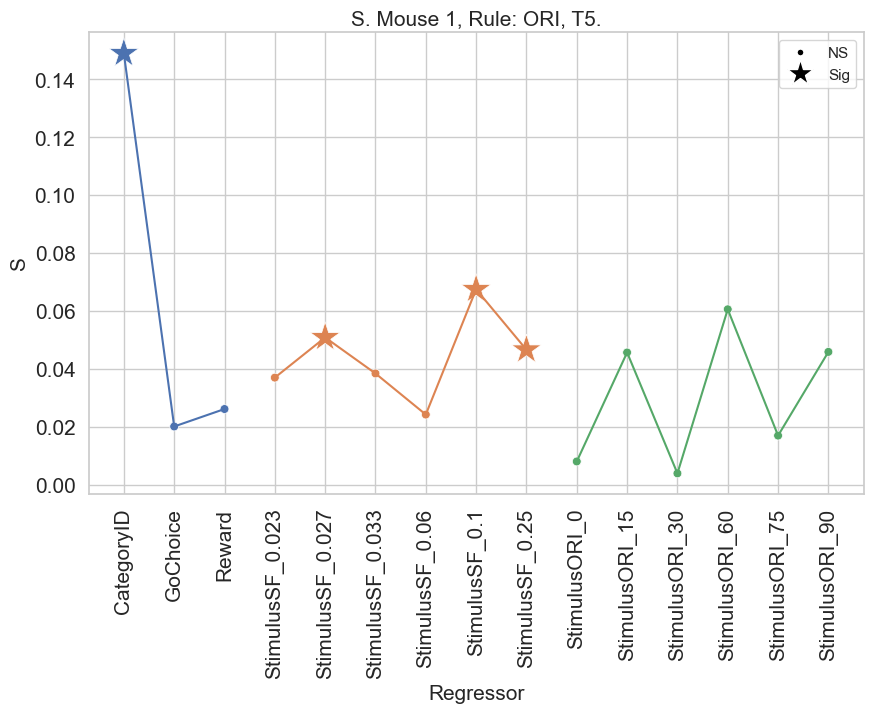

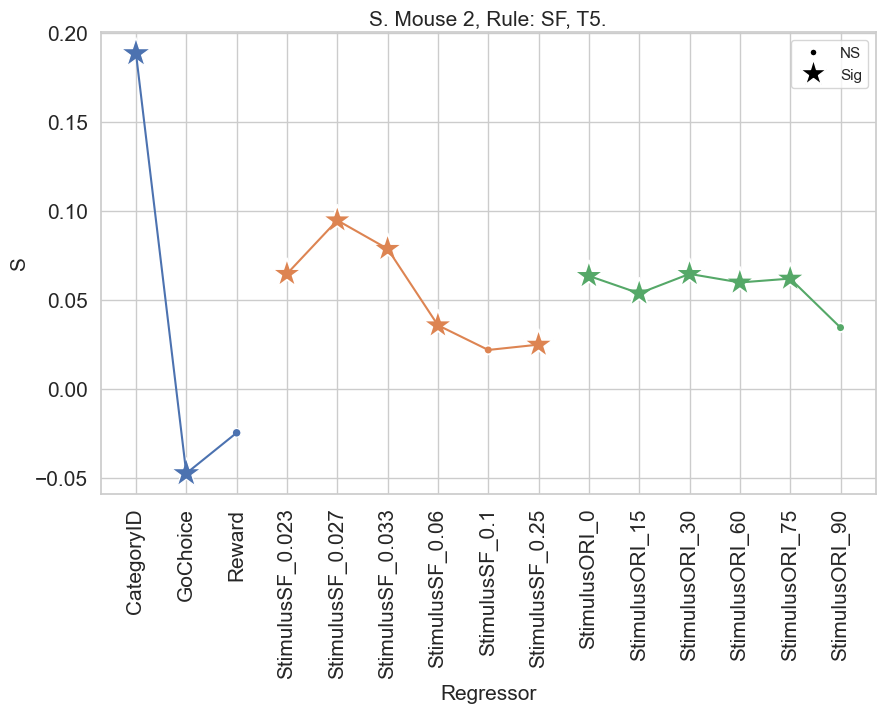

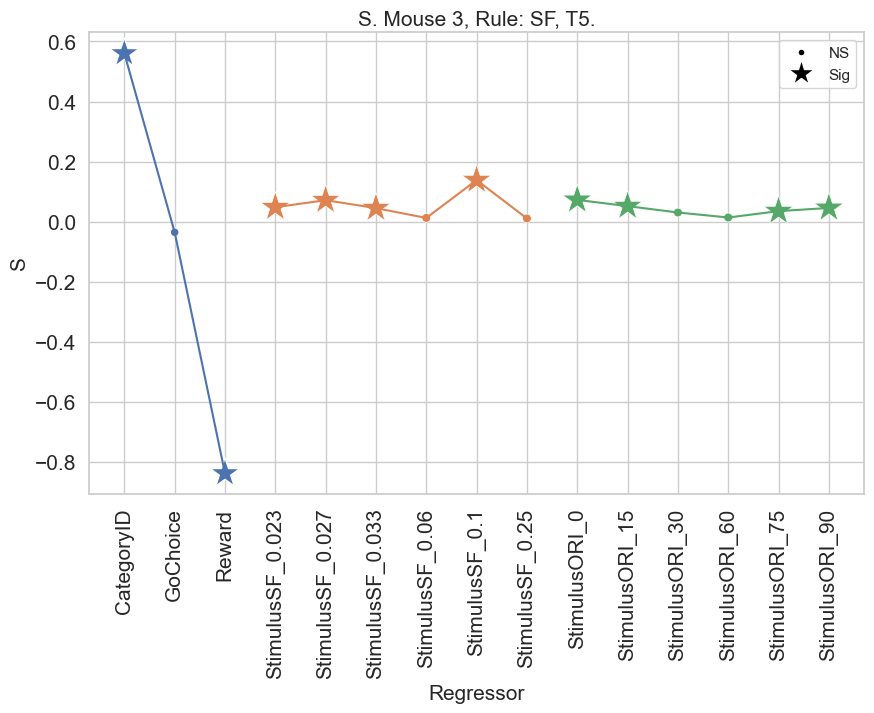

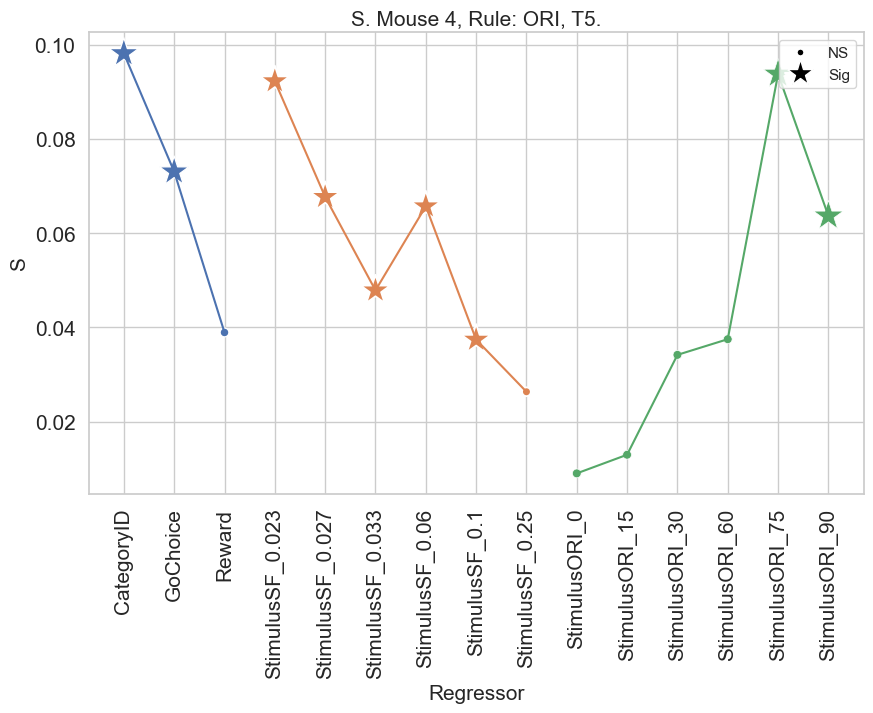

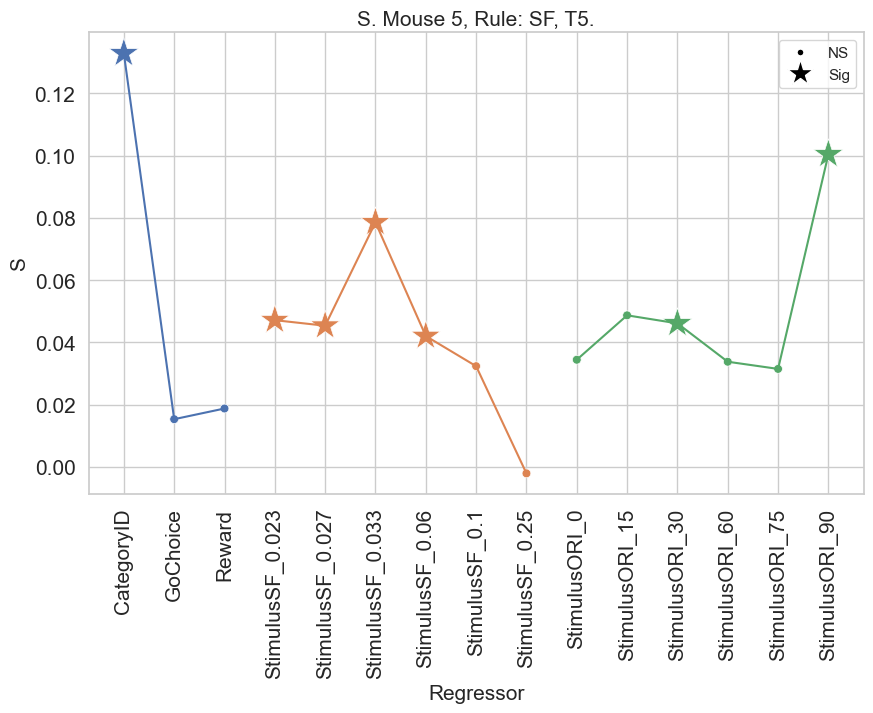

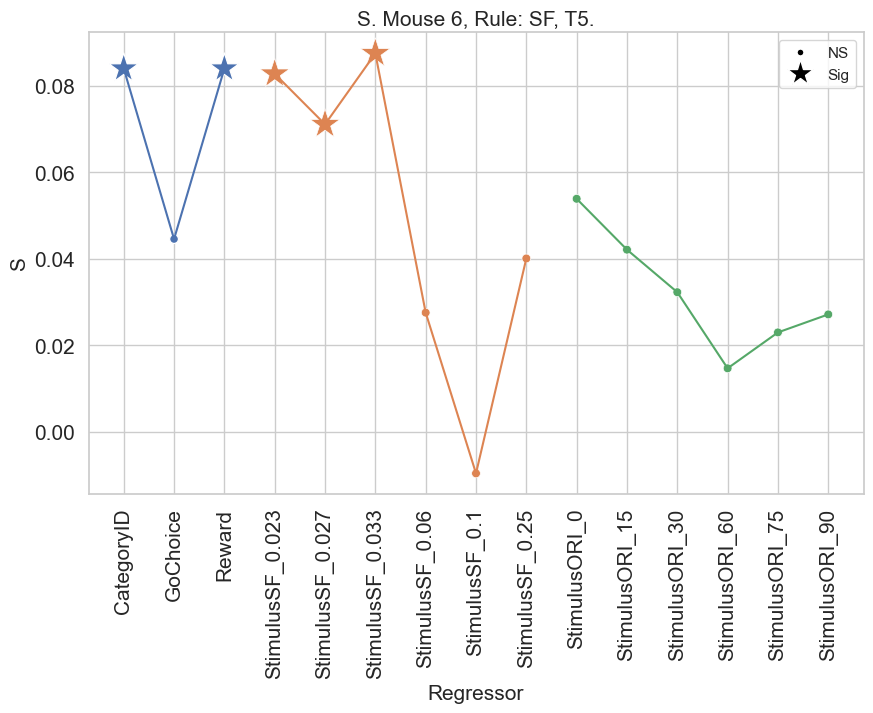

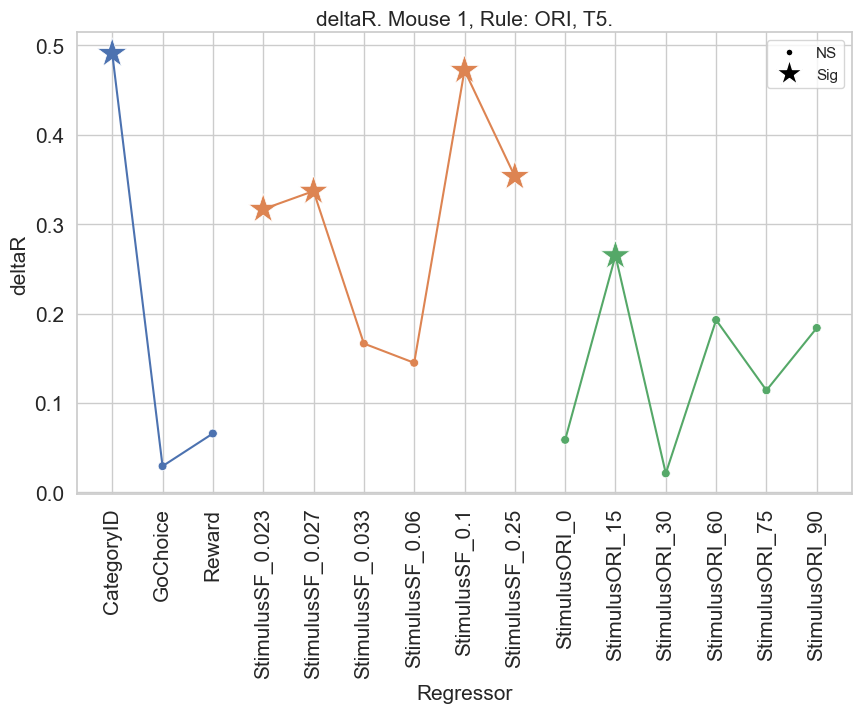

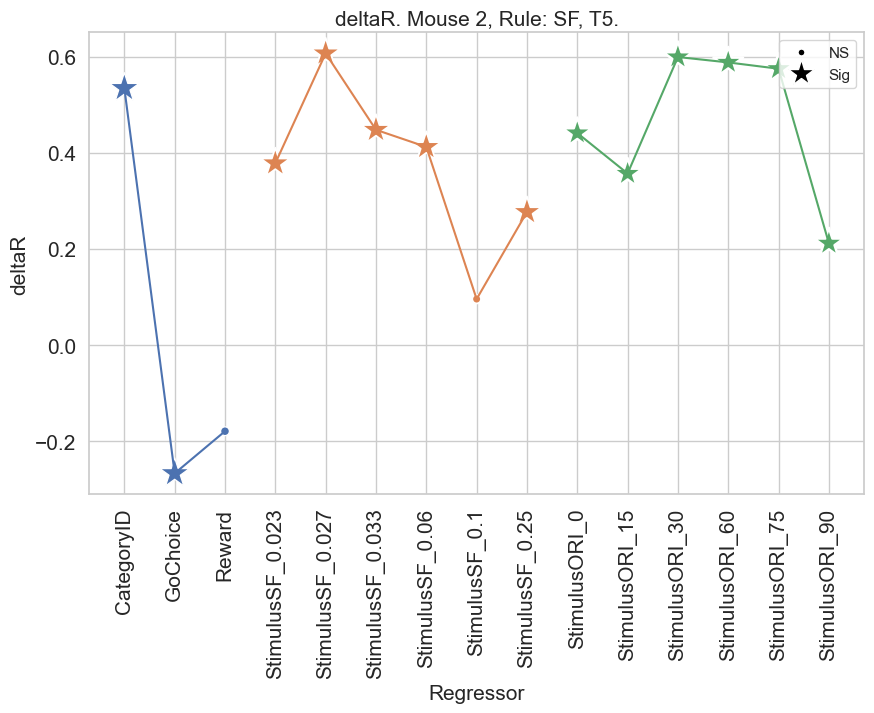

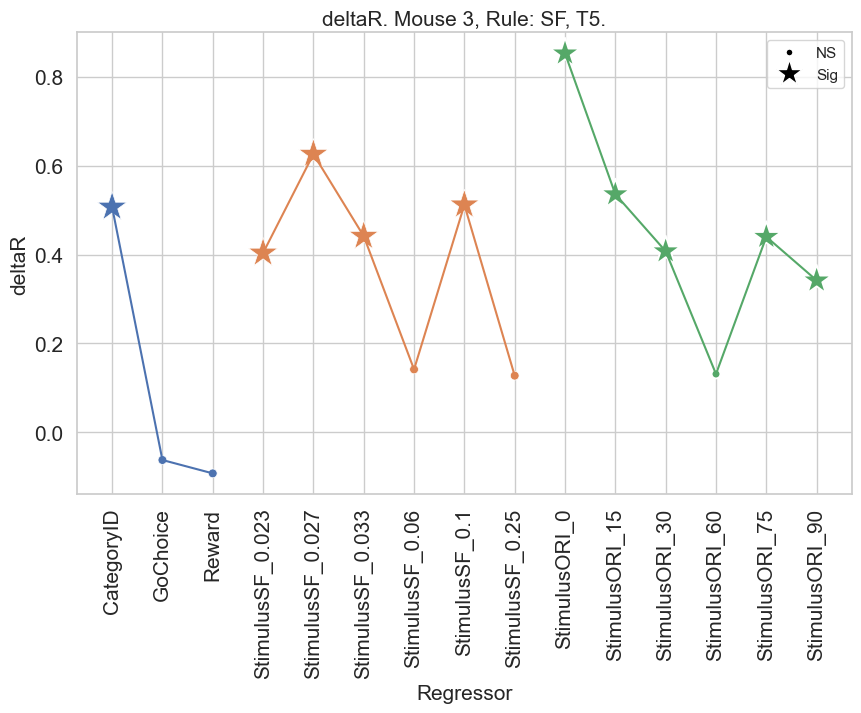

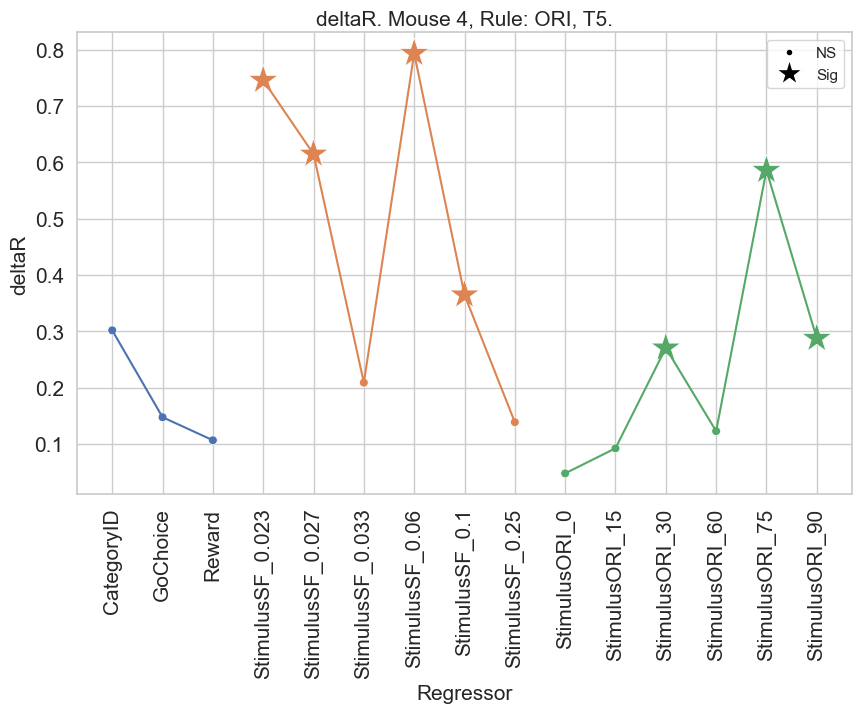

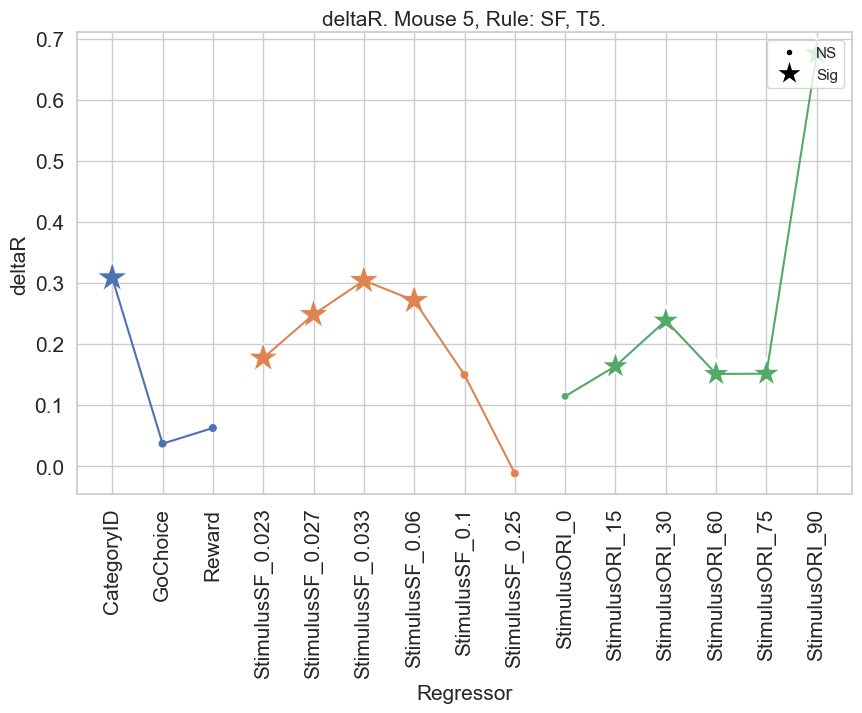

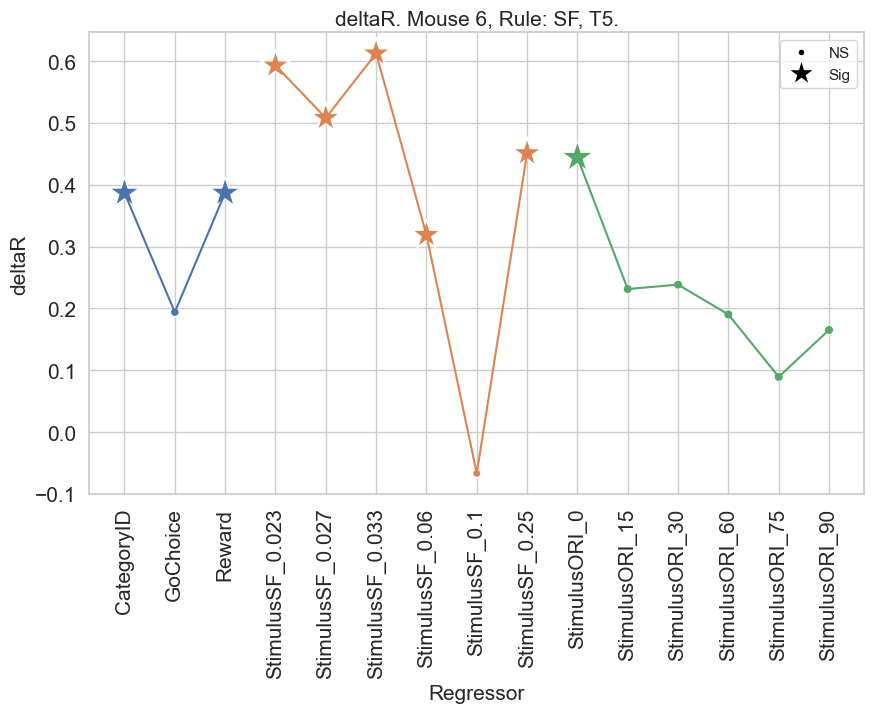

<Figure size 1000x600 with 0 Axes>

In [17]:
# Plot uncorrected mice 1-6
for index, mouse in enumerate(mice):
    plot_b2b_result(S_mice1_6_T5[index], "S", mouse, rule = rules[str(mouse)], stats = True, session = "T5", save = True, file_dir = os.getcwd() + "/b2b/figures/T5/b2b_mice1_6/")
for index, mouse in enumerate(mice):
    plot_b2b_result(deltaR_mice1_6_T5[index], "deltaR", mouse, rule = rules[str(mouse)], stats = True, session = "T5", save = True, file_dir = os.getcwd() + "/b2b/figures/T5/b2b_mice1_6/")

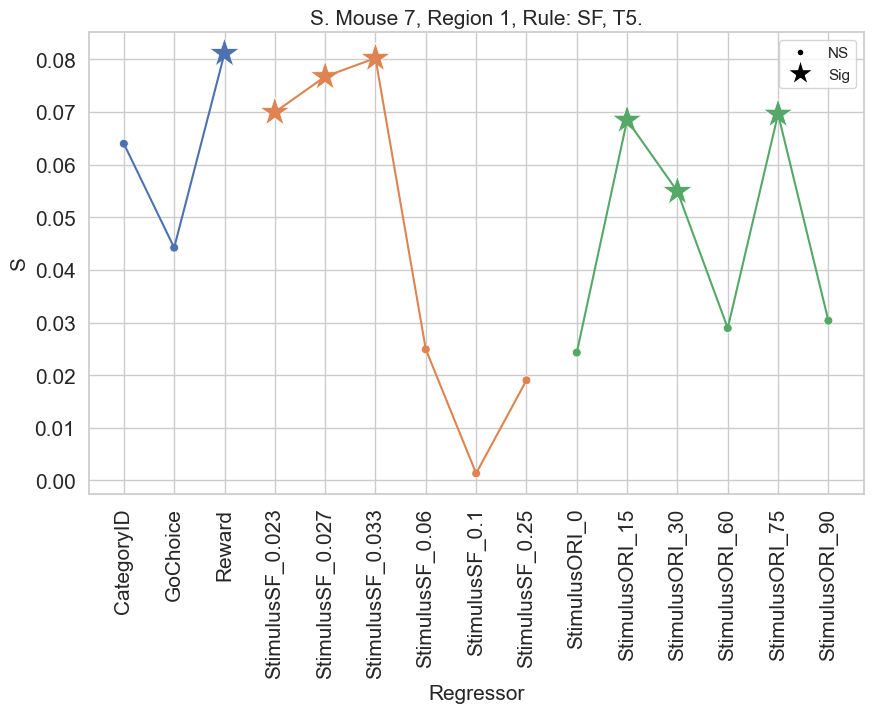

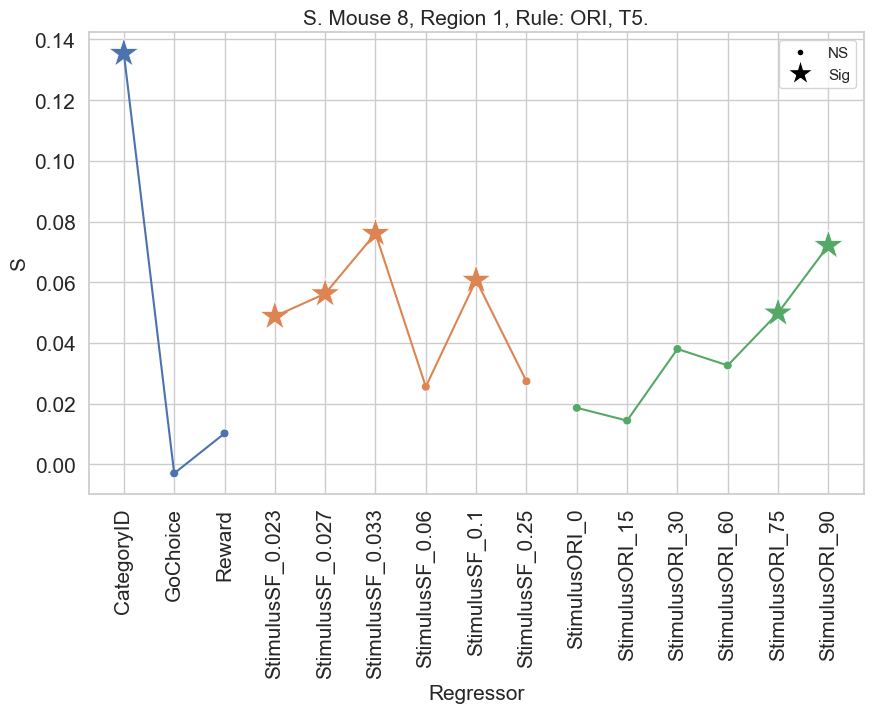

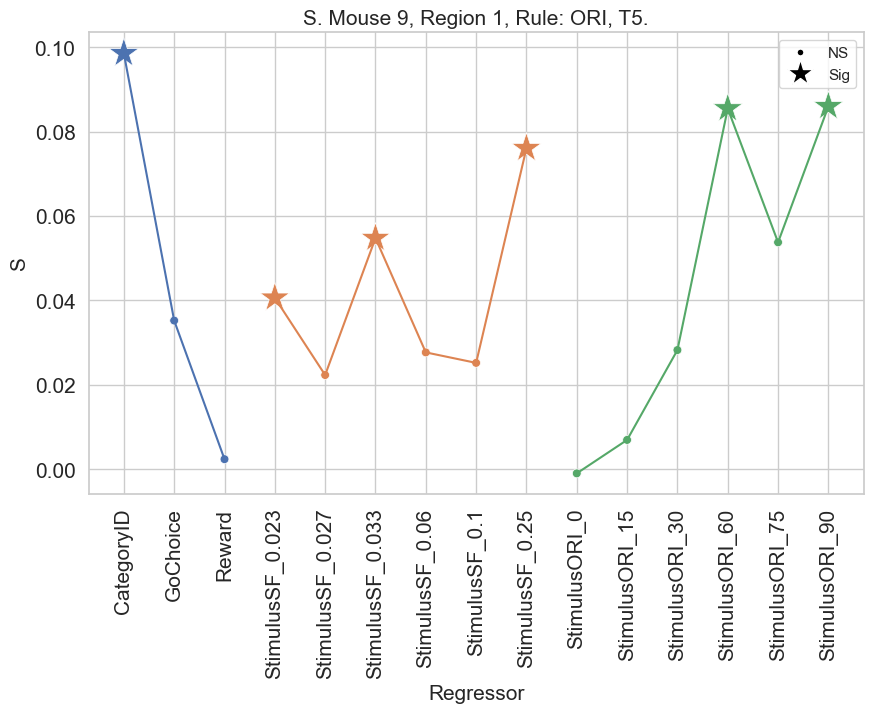

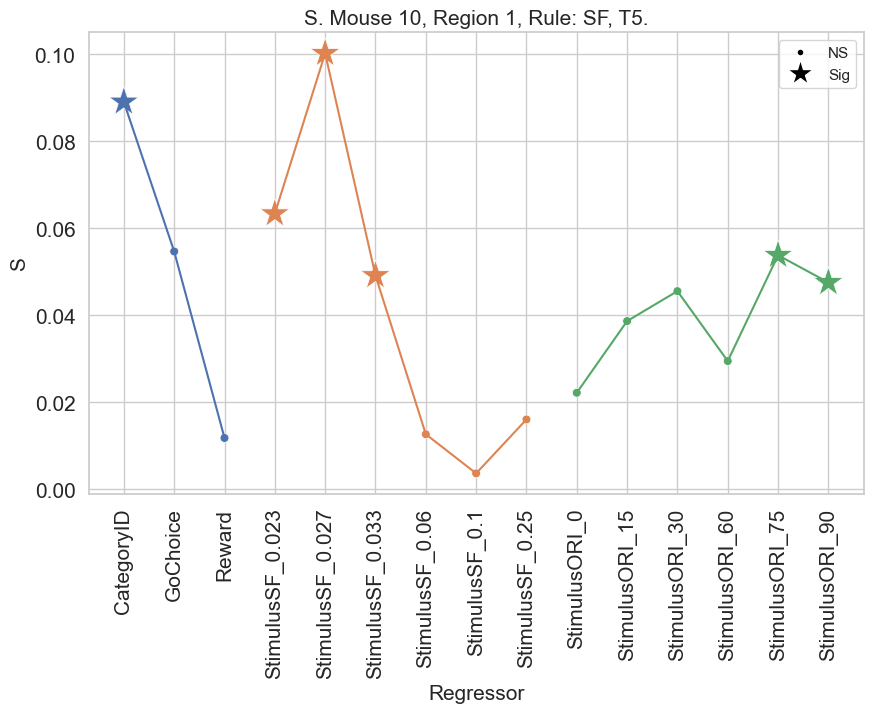

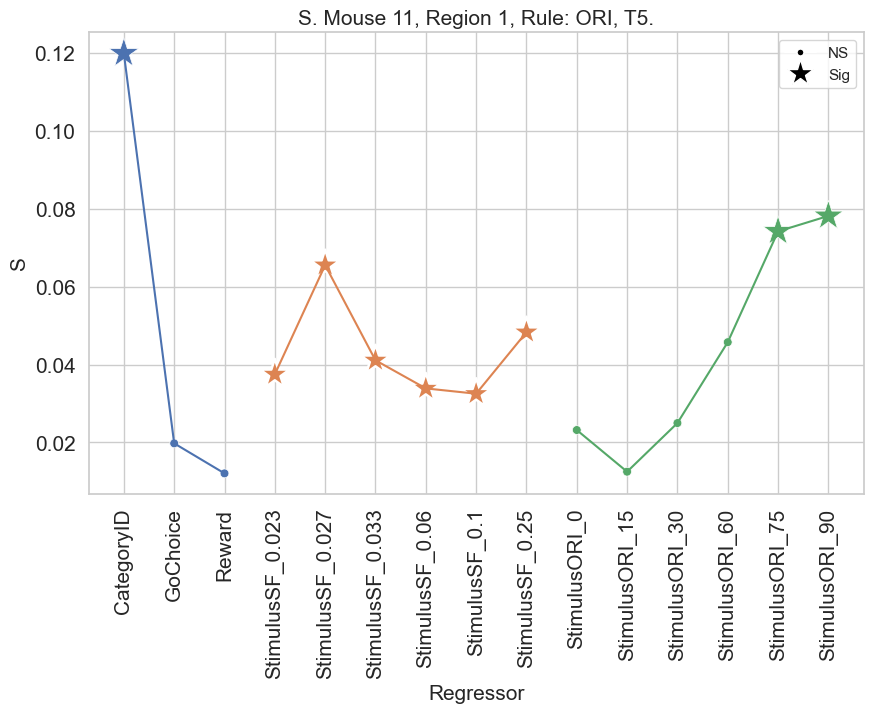

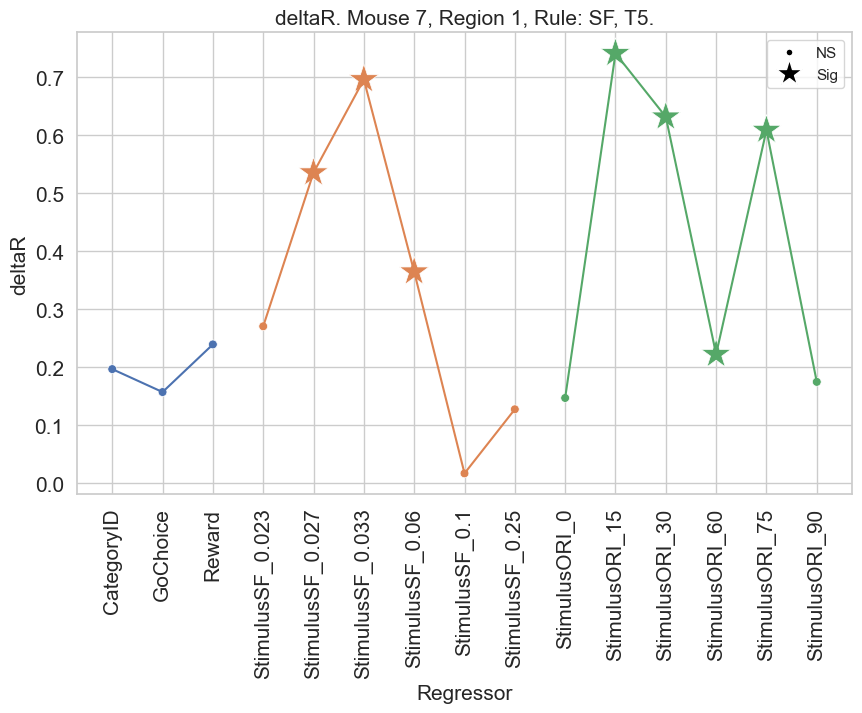

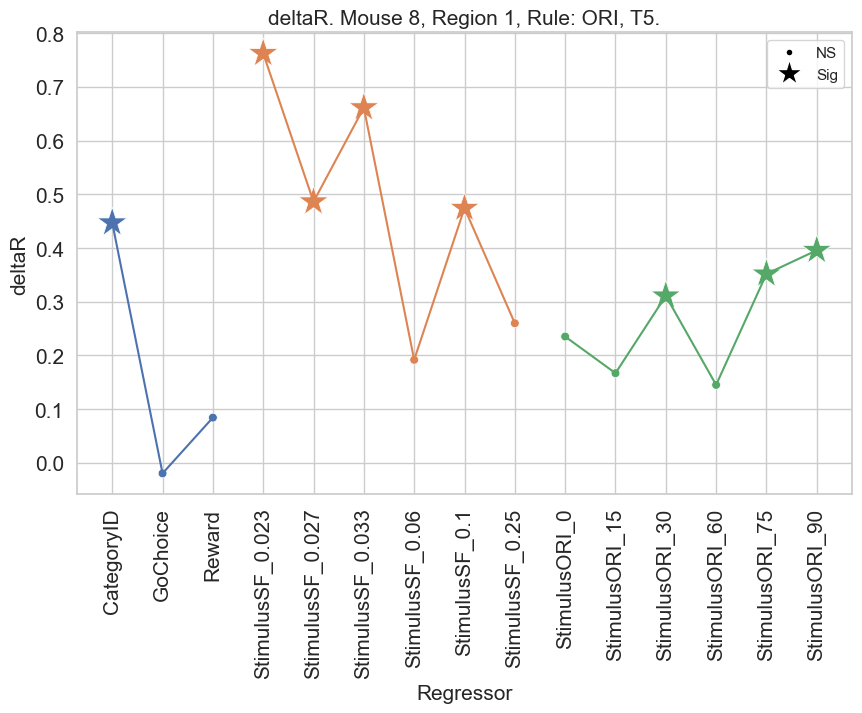

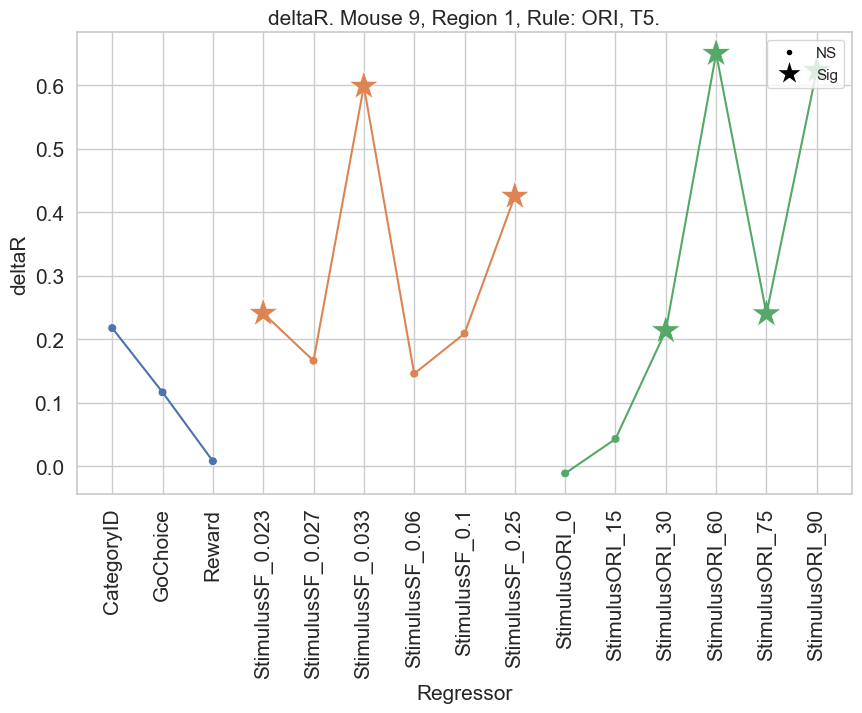

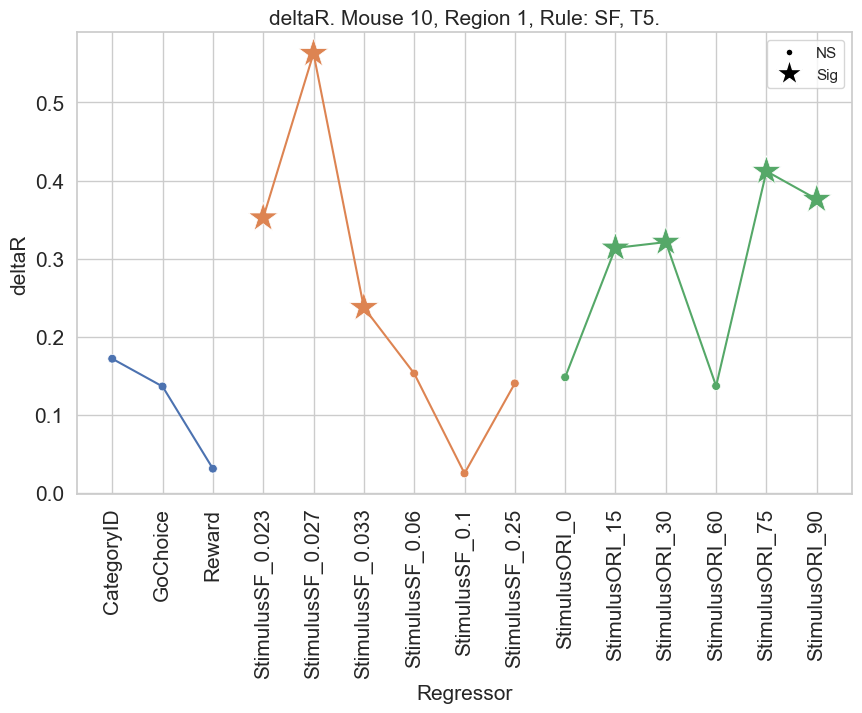

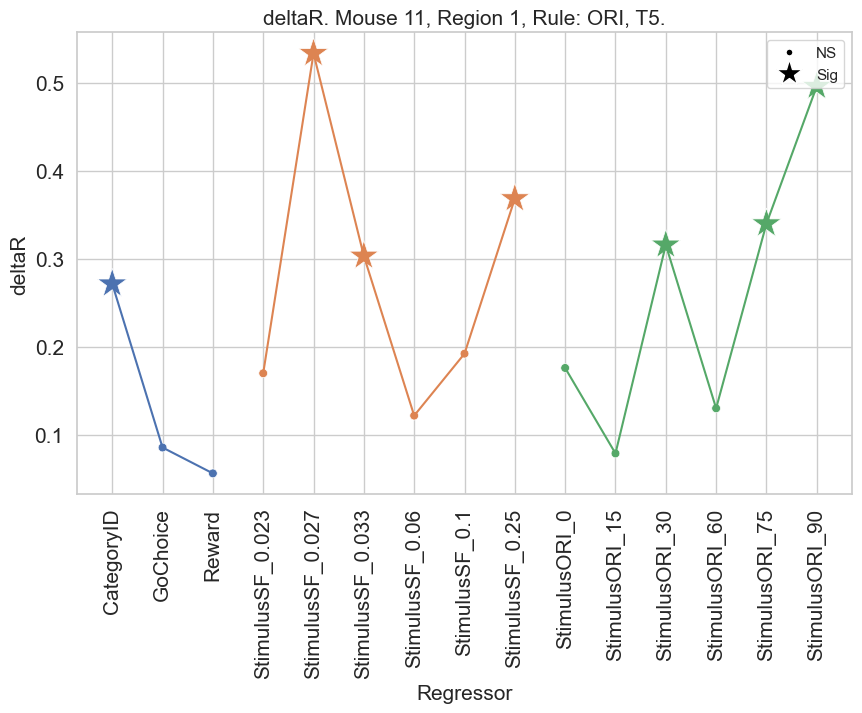

<Figure size 1000x600 with 0 Axes>

In [18]:
# Plot uncorrected mice 7-11, region 1
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(S_mice7_11_region1_T5[index], "S", mouse, rule = rules_region[str(mouse)], stats = True, session = "T5", region = 1, save = True, file_dir = os.getcwd() + "/b2b/figures/T5/b2b_mice7_11_region1/")
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(deltaR_mice7_11_region1_T5[index], "deltaR", mouse, rule = rules_region[str(mouse)], stats = True, session = "T5", region = 1, save = True, file_dir=os.getcwd() + "/b2b/figures/T5/b2b_mice7_11_region1/")

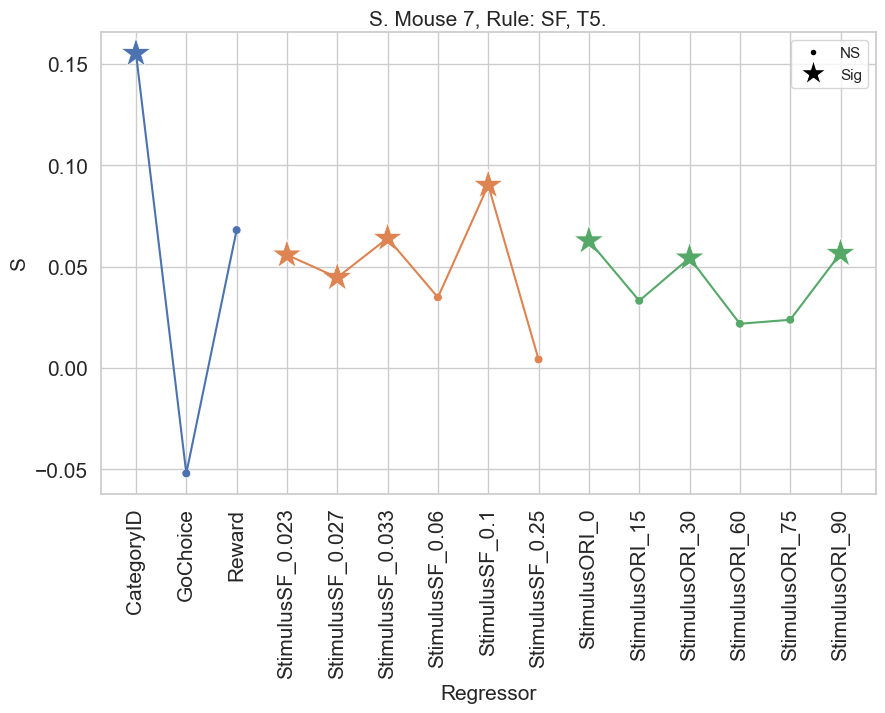

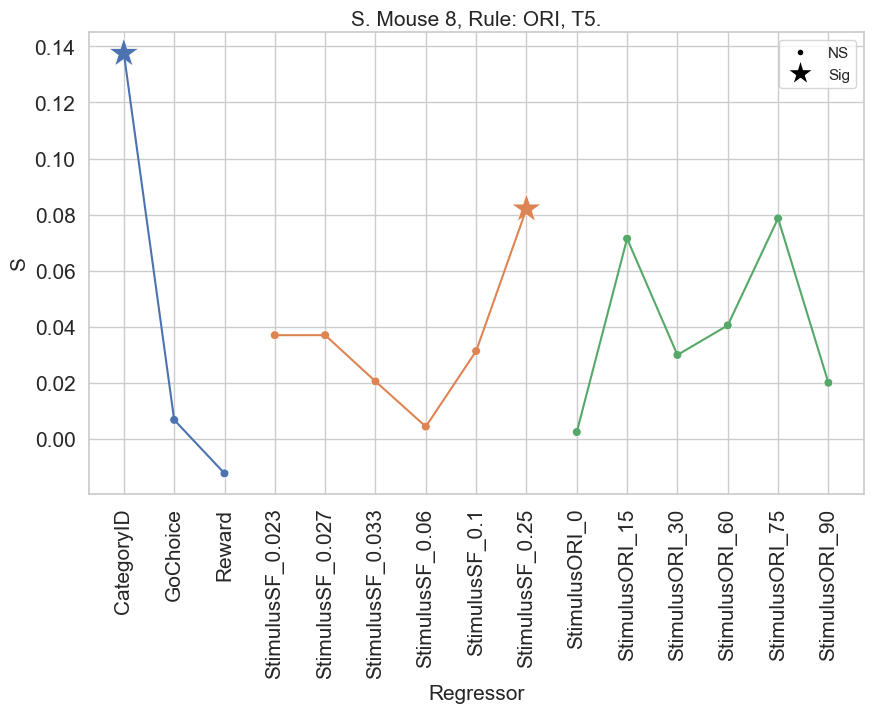

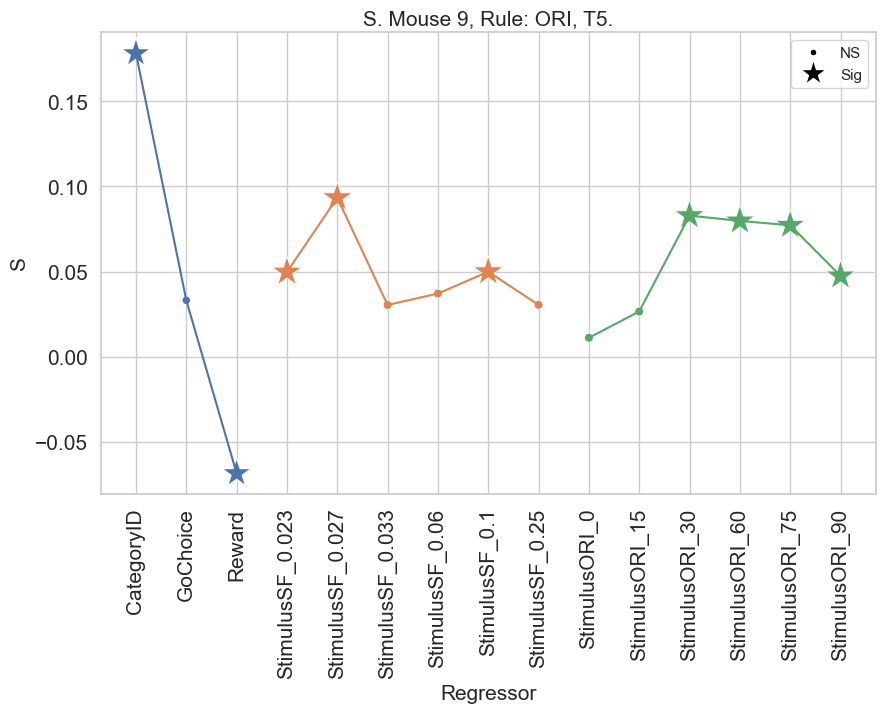

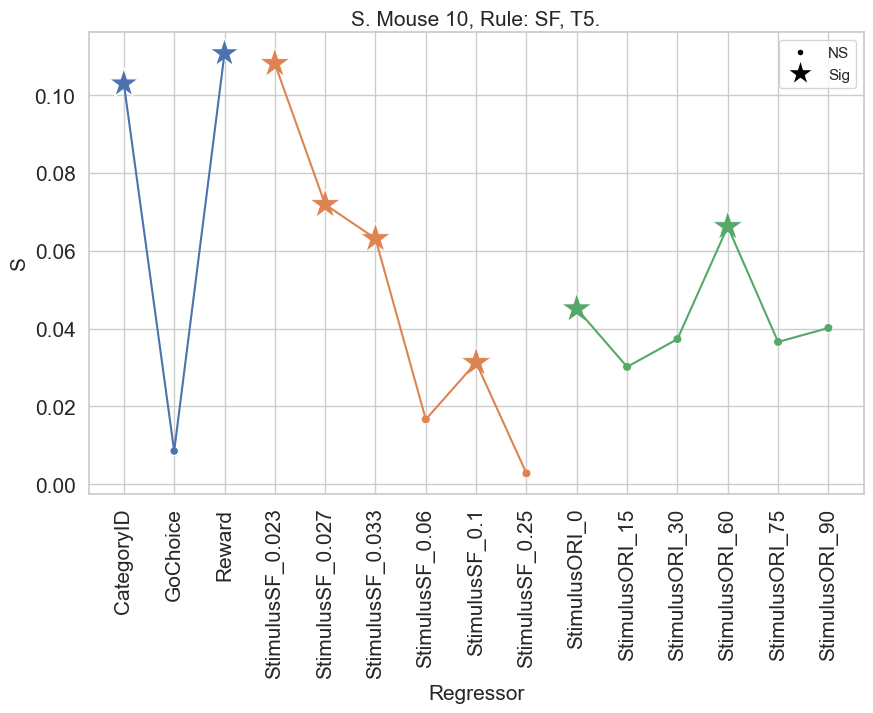

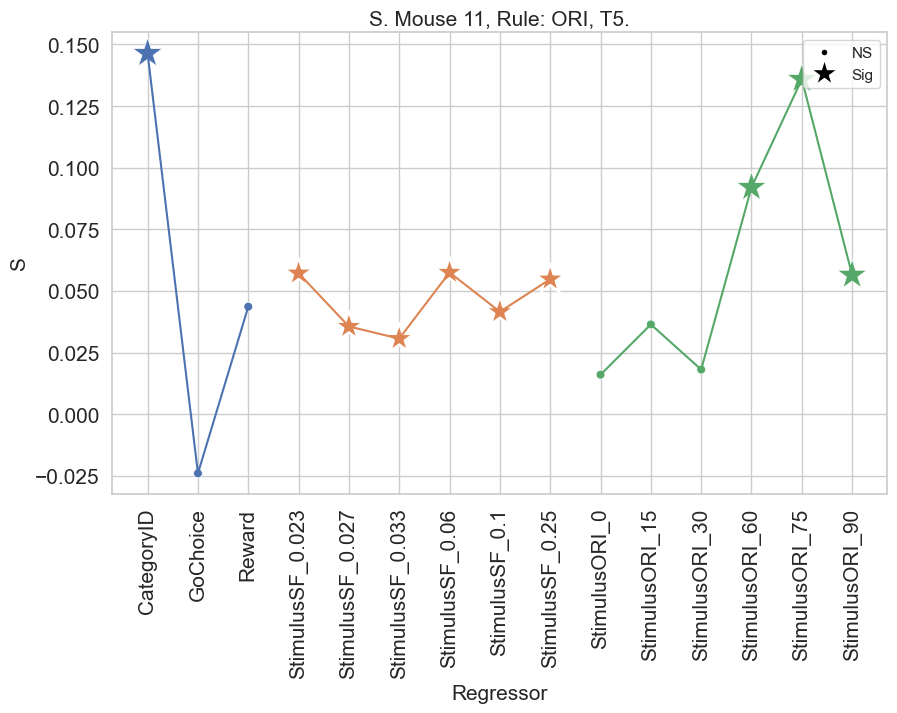

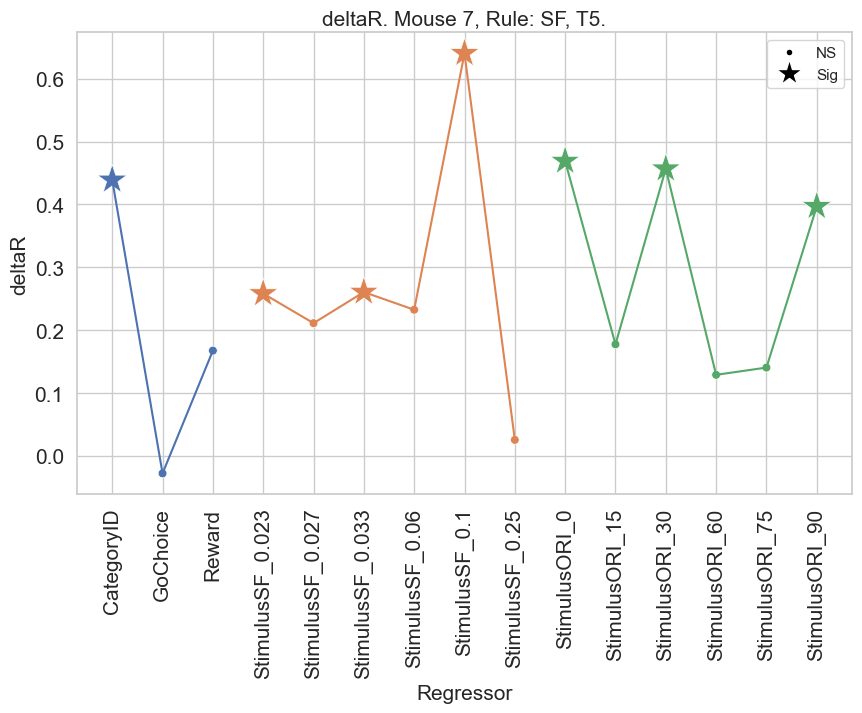

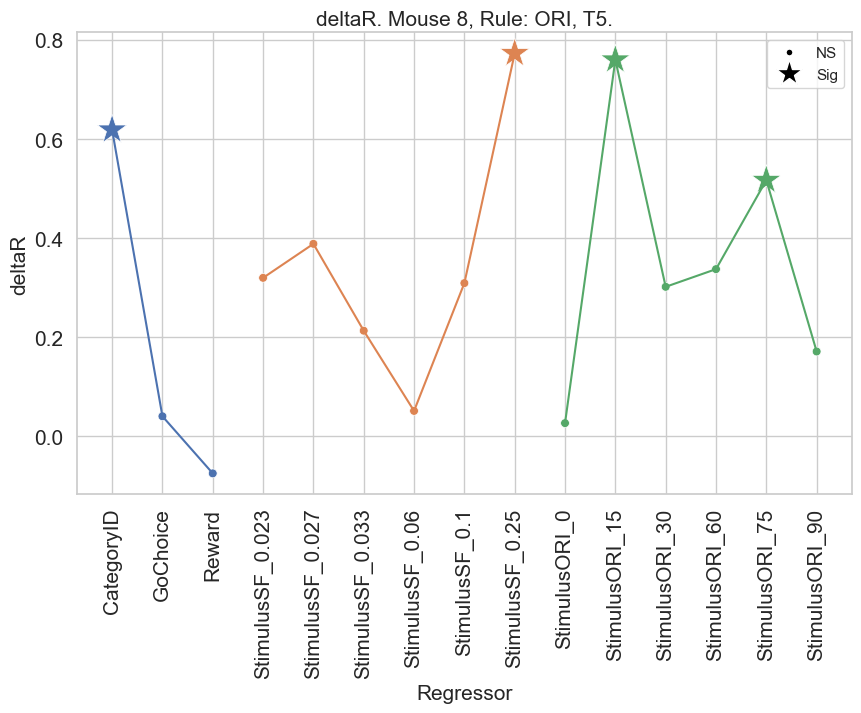

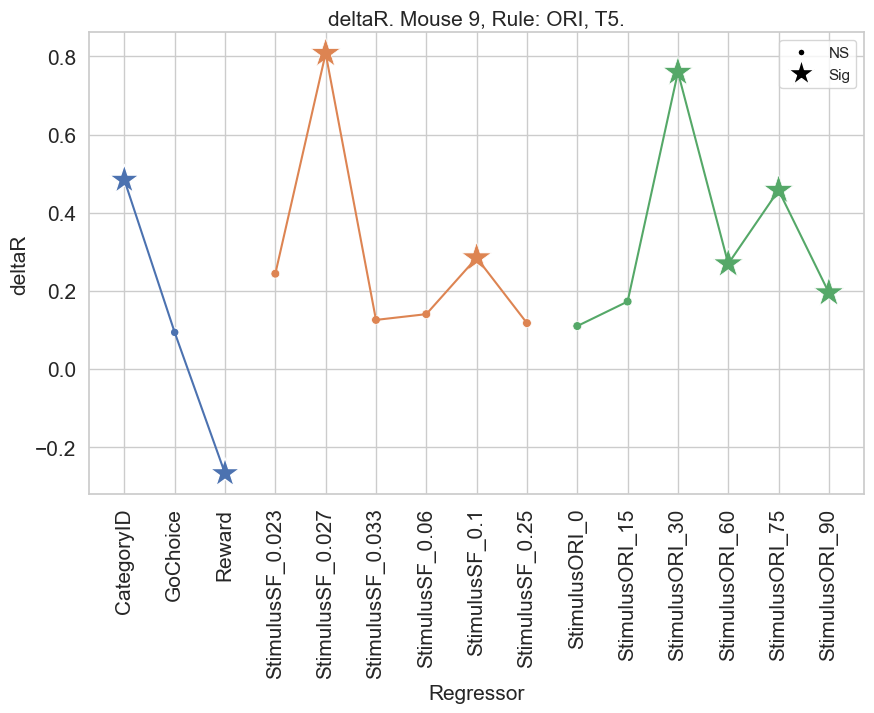

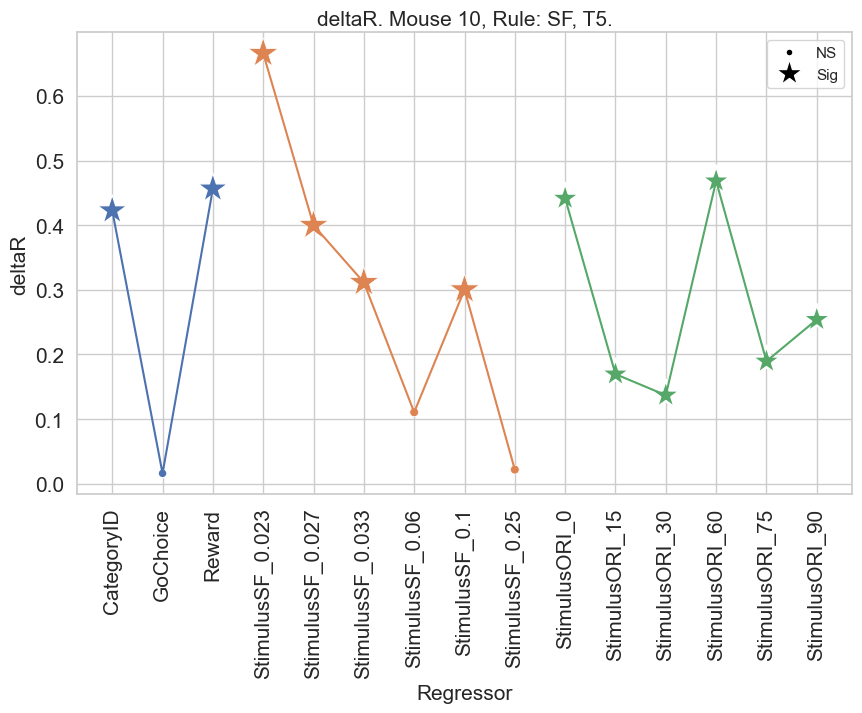

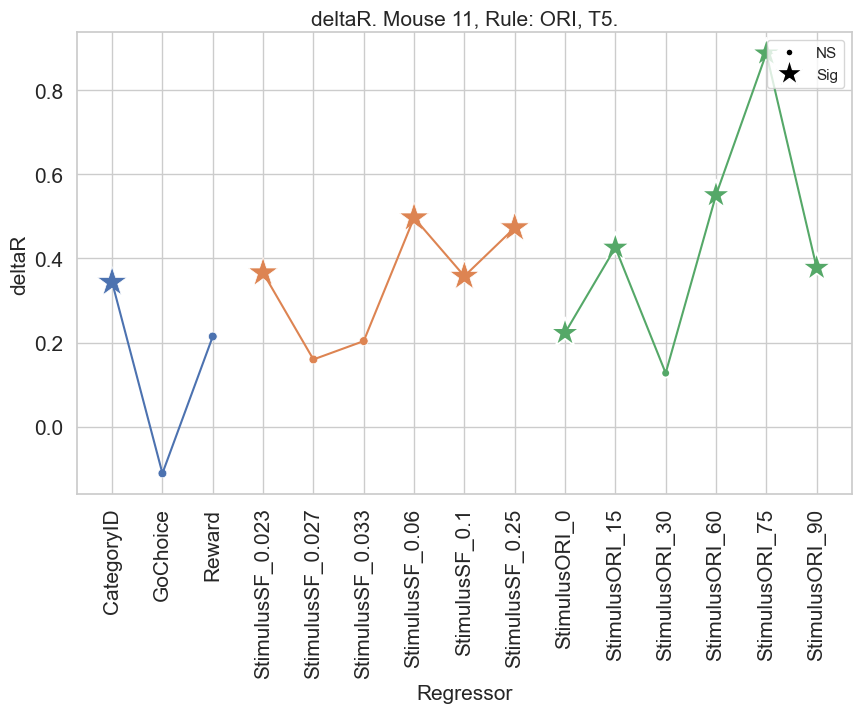

<Figure size 1000x600 with 0 Axes>

In [19]:
# Plot uncorrected mice 7-11, region 2
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(S_mice7_11_region2_T5[index], "S", mouse, rule = rules_region[str(mouse)], stats = True, session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/b2b_mice7_11_region2/")
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(deltaR_mice7_11_region2_T5[index], "deltaR", mouse, rule = rules_region[str(mouse)], stats = True, session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/b2b_mice7_11_region2/")

## Do FDR Correction

In [20]:
from statsmodels.stats.multitest import fdrcorrection

deltaR_mice1_6_T5_fdr = []
for i, mouse in enumerate(mice):
    deltaR_mouse1_6_T5 = deltaR_mice1_6_T5[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse1_6_T5["p-value"] = fdrcorrection(deltaR_mice1_6_T5[i]["p-value"].values)[1]
    deltaR_mouse1_6_T5["Sig."] = fdrcorrection(deltaR_mice1_6_T5[i]["p-value"].values)[0]
    deltaR_mouse1_6_T5.to_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice1_6/fdr_corrected/FDR_deltaR_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))
    deltaR_mice1_6_T5_fdr.append(deltaR_mouse1_6_T5)

deltaR_mice7_11_region1_T5_fdr = []
for i, mouse in enumerate(mice_regions):
    deltaR_mouse7_11_region1_T5 = deltaR_mice7_11_region1_T5[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse7_11_region1_T5["p-value"] = fdrcorrection(deltaR_mice7_11_region1_T5[i]["p-value"].values)[1]
    deltaR_mouse7_11_region1_T5["Sig."] = fdrcorrection(deltaR_mice7_11_region1_T5[i]["p-value"].values)[0]
    deltaR_mouse7_11_region1_T5.to_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region1/fdr_corrected/FDR_deltaR_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    deltaR_mice7_11_region1_T5_fdr.append(deltaR_mouse7_11_region1_T5)

deltaR_mice7_11_region2_T5_fdr = []
for i, mouse in enumerate(mice_regions):
    deltaR_mouse7_11_region2_T5 = deltaR_mice7_11_region2_T5[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse7_11_region2_T5["p-value"] = fdrcorrection(deltaR_mice7_11_region2_T5[i]["p-value"].values)[1]
    deltaR_mouse7_11_region2_T5["Sig."] = fdrcorrection(deltaR_mice7_11_region2_T5[i]["p-value"].values)[0]
    deltaR_mouse7_11_region2_T5.to_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region2/fdr_corrected/FDR_deltaR_mouse_%s_region2_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    deltaR_mice7_11_region2_T5_fdr.append(deltaR_mouse7_11_region2_T5)

In [21]:
S_mice1_6_T5_fdr = []
for i, mouse in enumerate(mice):
    S_mouse1_6_T5 = S_mice1_6_T5[i].drop(['p-value', 'Sig.'], axis=1) 
    S_mouse1_6_T5["p-value"] = fdrcorrection(S_mice1_6_T5[i]["p-value"].values)[1]
    S_mouse1_6_T5["Sig."] = fdrcorrection(S_mice1_6_T5[i]["p-value"].values)[0]
    S_mouse1_6_T5.to_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice1_6/fdr_corrected/FDR_S_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))
    S_mice1_6_T5_fdr.append(S_mouse1_6_T5)

S_mice7_11_region1_T5_fdr = []
for i, mouse in enumerate(mice_regions):
    S_mouse7_11_region1_T5 = S_mice7_11_region1_T5[i].drop(['p-value', 'Sig.'], axis=1) 
    S_mouse7_11_region1_T5["p-value"] = fdrcorrection(S_mice7_11_region1_T5[i]["p-value"].values)[1]
    S_mouse7_11_region1_T5["Sig."] = fdrcorrection(S_mice7_11_region1_T5[i]["p-value"].values)[0]
    S_mouse7_11_region1_T5.to_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region1/fdr_corrected/FDR_S_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    S_mice7_11_region1_T5_fdr.append(S_mouse7_11_region1_T5)

S_mice7_11_region2_T5_fdr = []
for i, mouse in enumerate(mice_regions):
    S_mouse7_11_region2_T5 = S_mice7_11_region2_T5[i].drop(['p-value', 'Sig.'], axis=1) 
    S_mouse7_11_region2_T5["p-value"] = fdrcorrection(S_mice7_11_region2_T5[i]["p-value"].values)[1]
    S_mouse7_11_region2_T5["Sig."] = fdrcorrection(S_mice7_11_region2_T5[i]["p-value"].values)[0]
    S_mouse7_11_region2_T5.to_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region2/fdr_corrected/FDR_S_mouse_%s_region2_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    S_mice7_11_region2_T5_fdr.append(S_mouse7_11_region2_T5)

## Significance Index for Relevant Features

In [71]:
relevant_sig_indices_mice1_6 = []
for i, mouse in enumerate(mice):
    rule = rules[str(mouse)]
    sig_index = round(len(deltaR_mice1_6_T5_fdr[i][(deltaR_mice1_6_T5_fdr[i]["Regressor"].str.contains('Stimulus%s' % rule)) & (deltaR_mice1_6_T5_fdr[i]["Sig."] == True)])/6, 2)
    relevant_sig_indices_mice1_6.append(sig_index)
relevant_sig_indices_mice1_6

round(np.mean(relevant_sig_indices_mice1_6), 2)

[0.17, 0.83, 0.67, 0.5, 0.5, 0.83]

0.58

[0.17, 0.83, 0.67, 0.5, 0.5, 0.83, 0.5, 0.5, 0.5, 0.33, 0.5]

In [70]:
relevant_sig_indices_mice7_11_region1 = []
for i, mouse in enumerate(mice_regions):
    rule = rules_region[str(mouse)]
    sig_index = round(len(deltaR_mice7_11_region1_T5_fdr[i][(deltaR_mice7_11_region1_T5_fdr[i]["Regressor"].str.contains('Stimulus%s' % rule)) & (deltaR_mice7_11_region1_T5_fdr[i]["Sig."] == True)])/6, 2)
    relevant_sig_indices_mice7_11_region1.append(sig_index)
relevant_sig_indices_mice7_11_region1
round(np.mean(relevant_sig_indices_mice7_11_region1), 2)

[0.5, 0.5, 0.5, 0.33, 0.5]

0.47

In [63]:
relevant_sig_indices_mice7_11_region2 = []
for i, mouse in enumerate(mice_regions):
    rule = rules_region[str(mouse)]
    sig_index = round(len(deltaR_mice7_11_region2_T5_fdr[i][(deltaR_mice7_11_region2_T5_fdr[i]["Regressor"].str.contains('Stimulus%s' % rule)) & (deltaR_mice7_11_region2_T5_fdr[i]["Sig."] == True)])/6, 2)
    relevant_sig_indices_mice7_11_region2.append(sig_index)
relevant_sig_indices_mice7_11_region2

round(np.mean(relevant_sig_indices_mice7_11_region2), 2)


[0.17, 0.33, 0.5, 0.67, 0.83]

0.5

## Significance Index for Irrelevant Features

In [68]:
irrelevant_sig_indices_mice1_6 = []
for i, mouse in enumerate(mice):
    rule = rules[str(mouse)]
    if rule == "ORI":
        irr_feature = "SF"
    else:
        irr_feature = "ORI"
    sig_index = round(len(deltaR_mice1_6_T5_fdr[i][(deltaR_mice1_6_T5_fdr[i]["Regressor"].str.contains('Stimulus%s' % irr_feature)) & (deltaR_mice1_6_T5_fdr[i]["Sig."] == True)])/6, 2)
    irrelevant_sig_indices_mice1_6.append(sig_index)
irrelevant_sig_indices_mice1_6

round(np.mean(irrelevant_sig_indices_mice1_6), 2)

[0.67, 1.0, 0.83, 0.67, 0.67, 0.17]

0.67

In [66]:
irrelevant_sig_indices_mice7_11_region1 = []
for i, mouse in enumerate(mice_regions):
    rule = rules_region[str(mouse)]
    if rule == "ORI":
        irr_feature = "SF"
    else:
        irr_feature = "ORI"
    sig_index = round(len(deltaR_mice7_11_region1_T5_fdr[i][(deltaR_mice7_11_region1_T5_fdr[i]["Regressor"].str.contains('Stimulus%s' % irr_feature)) & (deltaR_mice7_11_region1_T5_fdr[i]["Sig."] == True)])/6, 2)
    irrelevant_sig_indices_mice7_11_region1.append(sig_index)
irrelevant_sig_indices_mice7_11_region1

round(np.mean(irrelevant_sig_indices_mice7_11_region1), 2)

[0.5, 0.67, 0.33, 0.67, 0.33]

0.5

In [67]:
irrelevant_sig_indices_mice7_11_region2 = []
for i, mouse in enumerate(mice_regions):
    rule = rules_region[str(mouse)]
    if rule == "ORI":
        irr_feature = "SF"
    else:
        irr_feature = "ORI"
    sig_index = round(len(deltaR_mice7_11_region2_T5_fdr[i][(deltaR_mice7_11_region2_T5_fdr[i]["Regressor"].str.contains('Stimulus%s' % irr_feature)) & (deltaR_mice7_11_region2_T5_fdr[i]["Sig."] == True)])/6, 2)
    irrelevant_sig_indices_mice7_11_region2.append(sig_index)
irrelevant_sig_indices_mice7_11_region2

round(np.mean(irrelevant_sig_indices_mice7_11_region2), 2)

[0.5, 0.17, 0.17, 0.83, 0.67]

0.47

In [72]:
relevant_sig_indices = relevant_sig_indices_mice1_6 + relevant_sig_indices_mice7_11_region1 + relevant_sig_indices_mice7_11_region2
irrelevant_sig_indices = irrelevant_sig_indices_mice1_6 + irrelevant_sig_indices_mice7_11_region1 + irrelevant_sig_indices_mice7_11_region2

In [74]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
mannwhitneyu(relevant_sig_indices_mice1_6, irrelevant_sig_indices_mice1_6)
wilcoxon(relevant_sig_indices_mice1_6, irrelevant_sig_indices_mice1_6)

MannwhitneyuResult(statistic=14.0, pvalue=0.5640641396373036)

WilcoxonResult(statistic=6.0, pvalue=0.4375)

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

deltaR_mice1_6_T1_fdr = []
for i, mouse in enumerate(mice):
    deltaR_mouse1_6_T1 = deltaR_mice1_6_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse1_6_T1["p-value"] = fdrcorrection(deltaR_mice1_6_T1[i]["p-value"].values)[1]
    deltaR_mouse1_6_T1["Sig."] = fdrcorrection(deltaR_mice1_6_T1[i]["p-value"].values)[0]
    deltaR_mouse1_6_T1.to_csv(os.getcwd() + "/b2b/csv/T1/b2b_mice1_6/fdr_corrected/FDR_deltaR_mouse_%s_region1_rule_%s_T1.csv" %(mouse, rules[str(mouse)]))
    deltaR_mice1_6_T1_fdr.append(deltaR_mouse1_6_T1)

deltaR_mice7_11_region1_T1_fdr = []
for i, mouse in enumerate(mice_regions):
    deltaR_mouse7_11_region1_T1 = deltaR_mice7_11_region1_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse7_11_region1_T1["p-value"] = fdrcorrection(deltaR_mice7_11_region1_T1[i]["p-value"].values)[1]
    deltaR_mouse7_11_region1_T1["Sig."] = fdrcorrection(deltaR_mice7_11_region1_T1[i]["p-value"].values)[0]
    deltaR_mouse7_11_region1_T1.to_csv(os.getcwd() + "/b2b/csv/T1/b2b_mice7_11_region1/fdr_corrected/FDR_deltaR_mouse_%s_region1_rule_%s_T1.csv" %(mouse, rules_region[str(mouse)]))
    deltaR_mice7_11_region1_T1_fdr.append(deltaR_mouse7_11_region1_T1)

deltaR_mice7_11_region2_T1_fdr = []
for i, mouse in enumerate(mice_regions):
    deltaR_mouse7_11_region2_T1 = deltaR_mice7_11_region2_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse7_11_region2_T1["p-value"] = fdrcorrection(deltaR_mice7_11_region2_T1[i]["p-value"].values)[1]
    deltaR_mouse7_11_region2_T1["Sig."] = fdrcorrection(deltaR_mice7_11_region2_T1[i]["p-value"].values)[0]
    deltaR_mouse7_11_region2_T1.to_csv(os.getcwd() + "/b2b/csv/T1/b2b_mice7_11_region2/fdr_corrected/FDR_deltaR_mouse_%s_region2_rule_%s_T1.csv" %(mouse, rules_region[str(mouse)]))
    deltaR_mice7_11_region2_T1_fdr.append(deltaR_mouse7_11_region2_T1)

In [ ]:
## Visualization of FDR-Corrected B2B Results

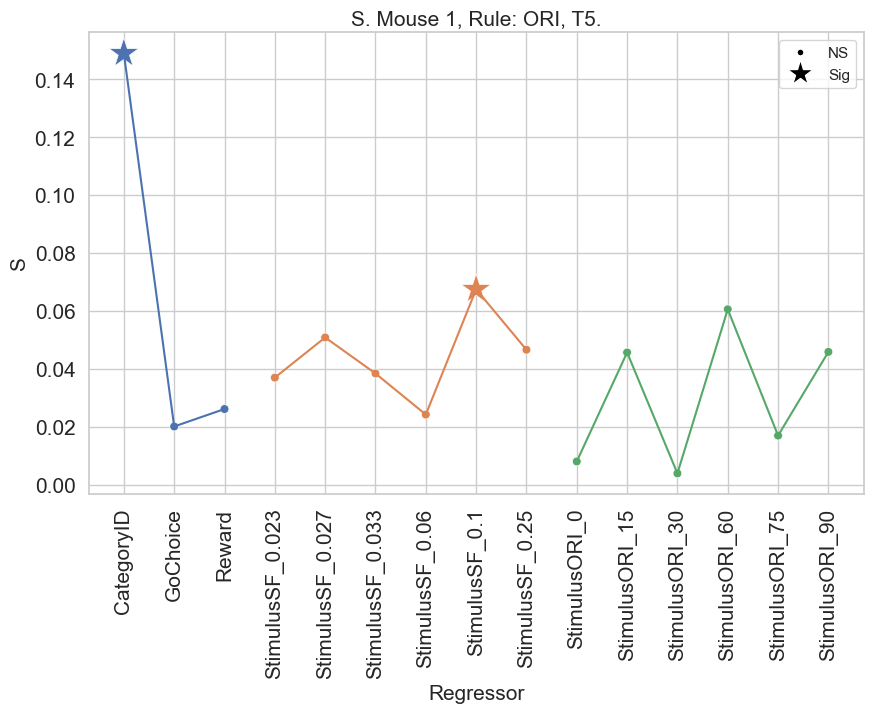

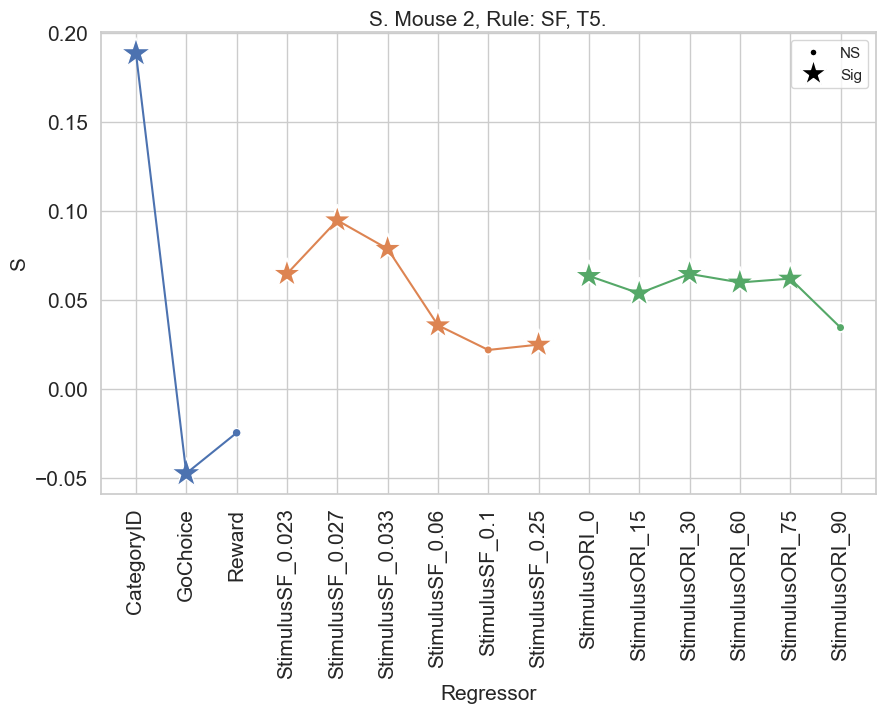

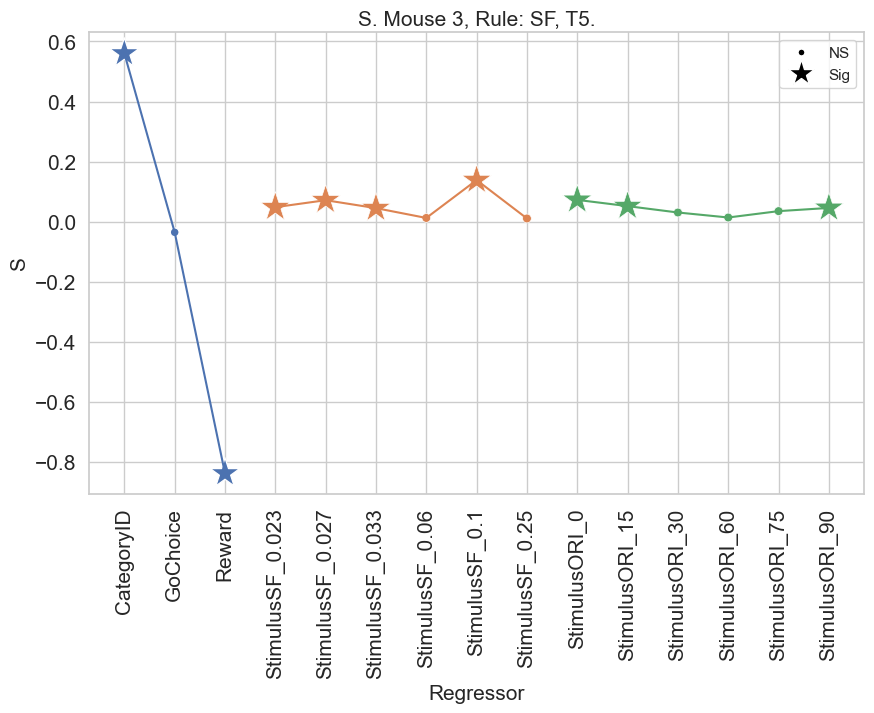

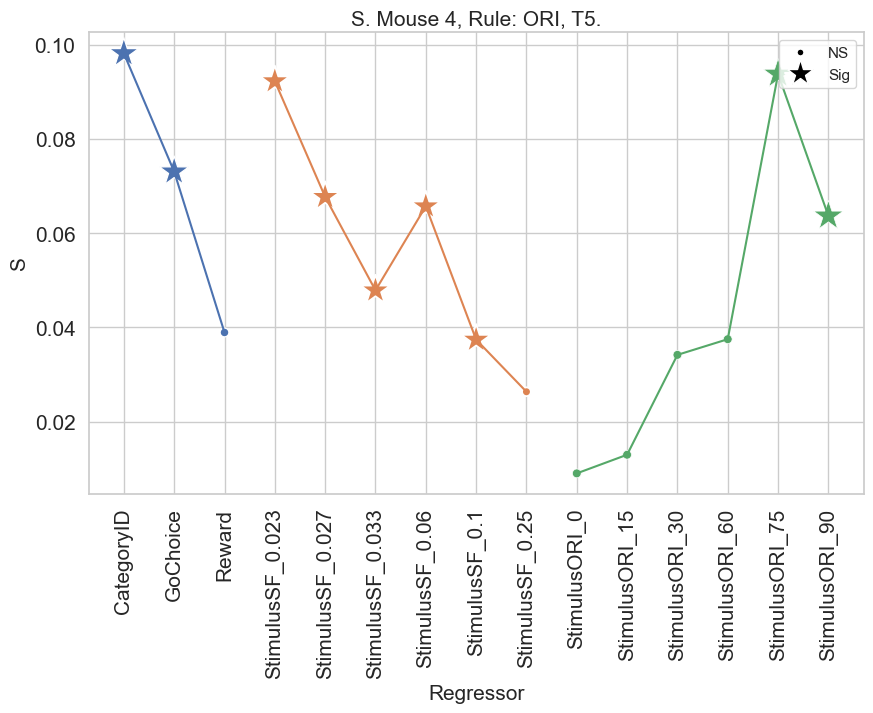

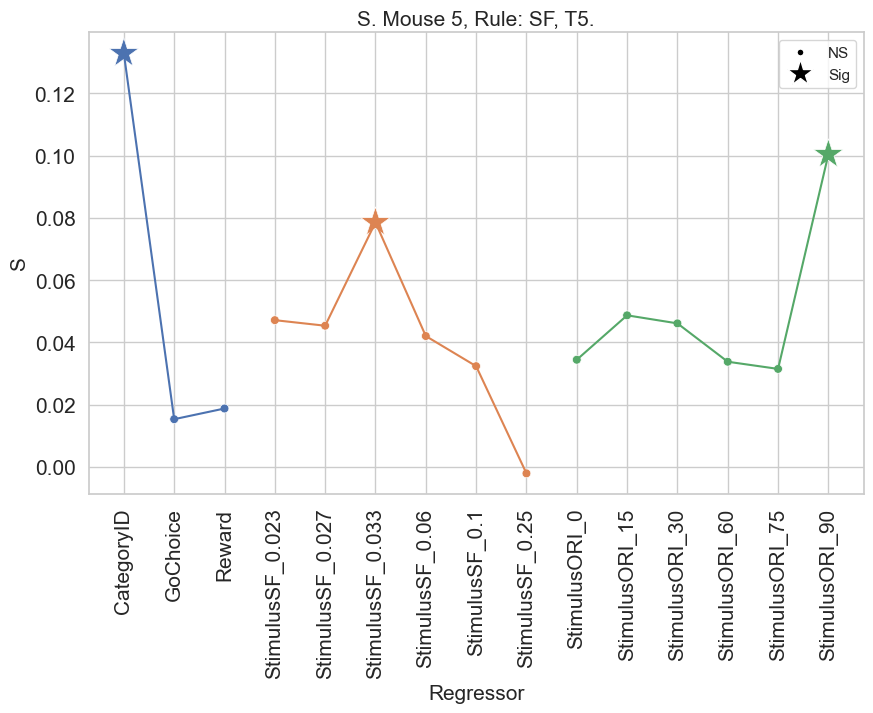

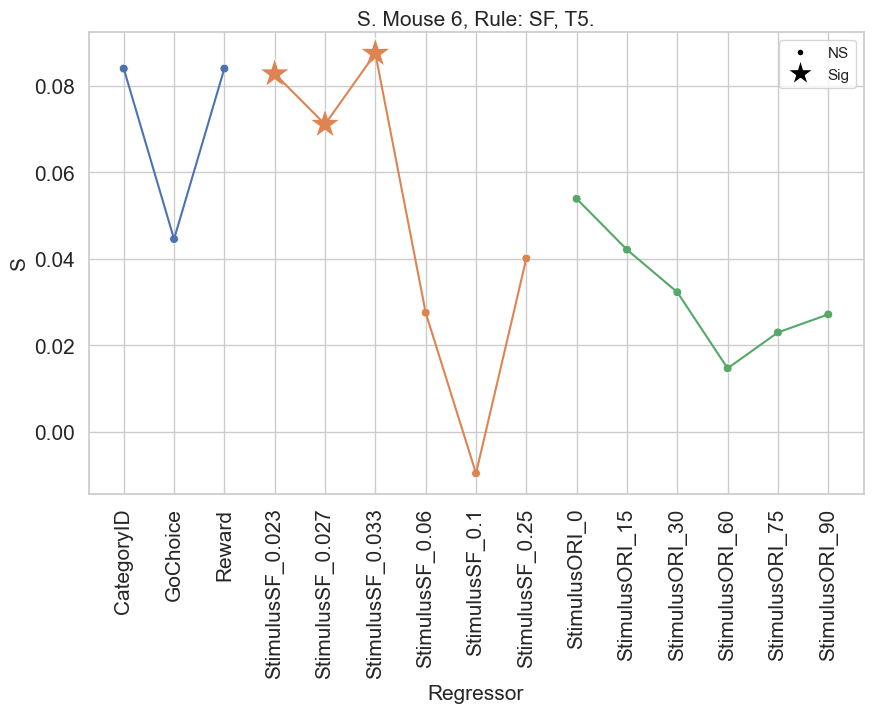

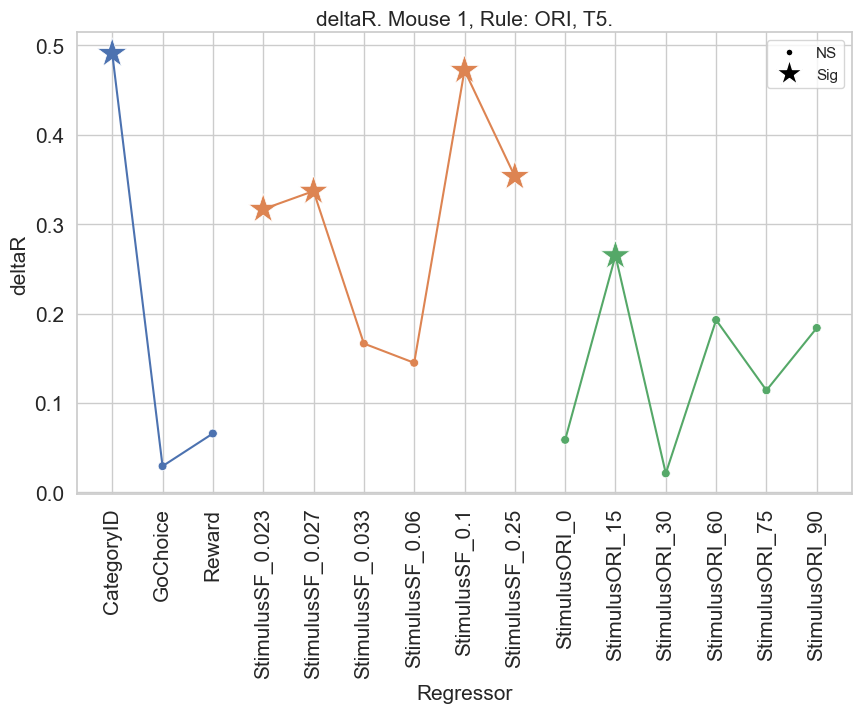

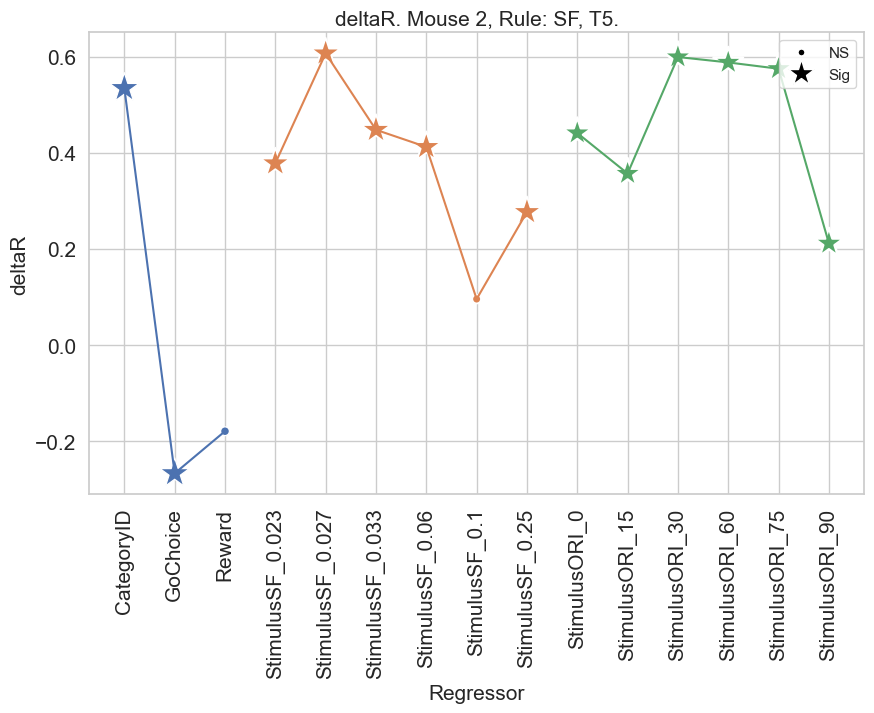

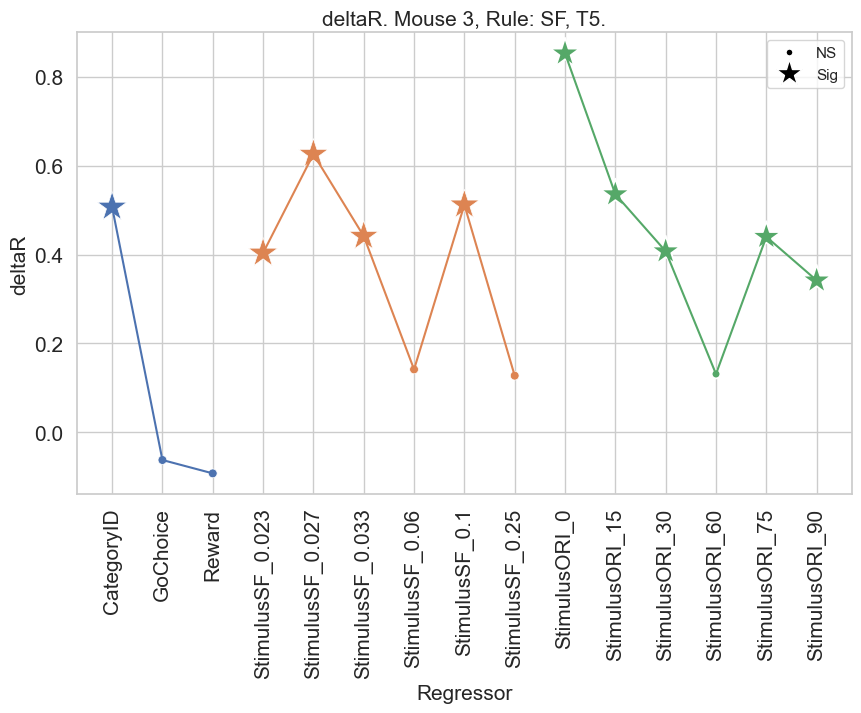

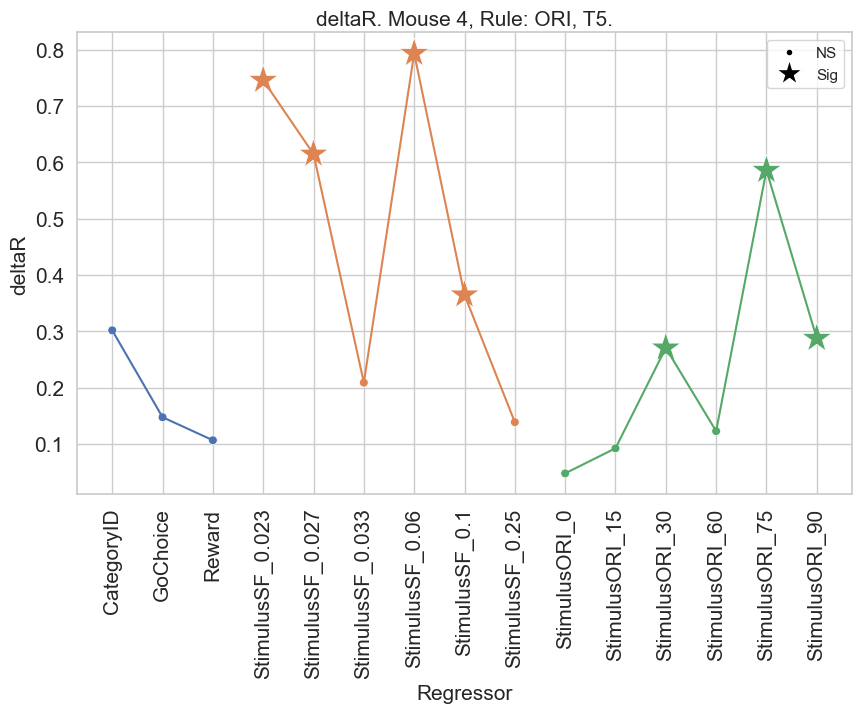

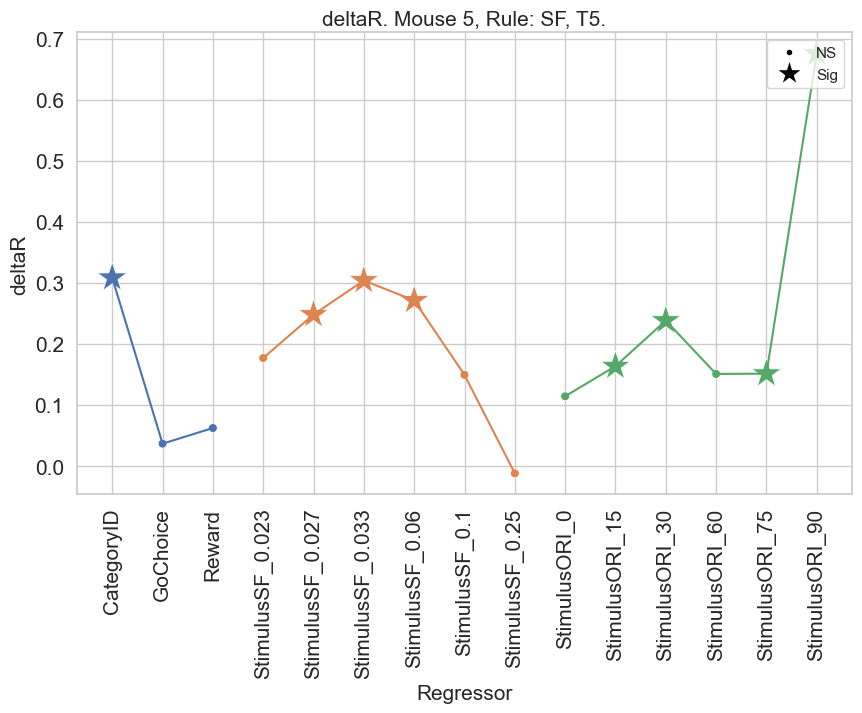

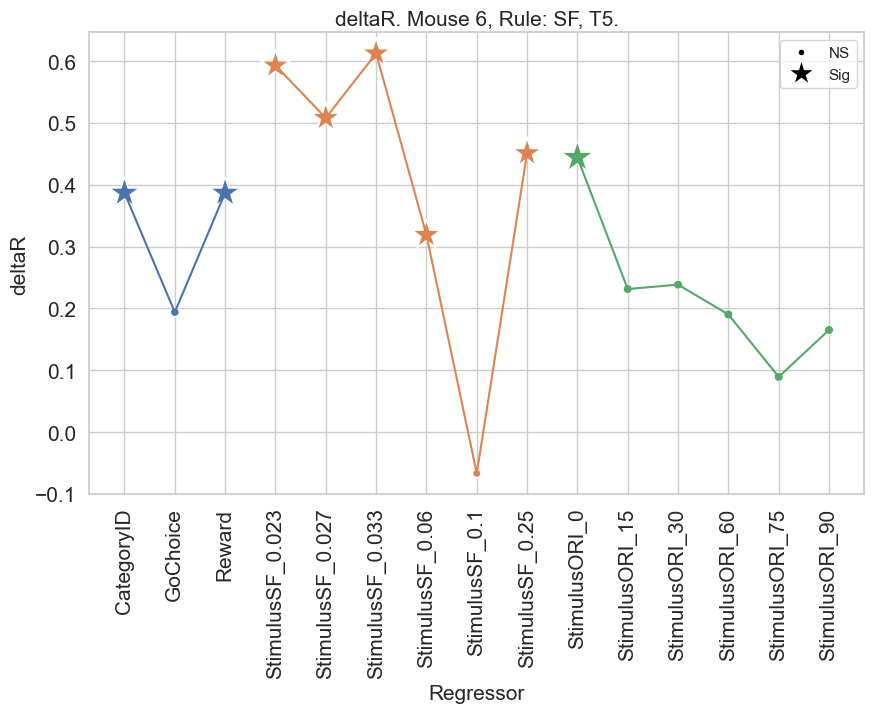

<Figure size 1000x600 with 0 Axes>

In [22]:
# Plot uncorrected mice 7-11, region 1
for index, mouse in enumerate(mice):
    plot_b2b_result(S_mice1_6_T5_fdr[index], "S", mouse, stats = True, rule = rules[str(mouse)], session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/fdr_corrected/b2b_mice1_6/FDR_")
for index, mouse in enumerate(mice):
    plot_b2b_result(deltaR_mice1_6_T5_fdr[index], "deltaR",  mouse, stats = True, rule = rules[str(mouse)], session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/fdr_corrected/b2b_mice1_6/FDR_")

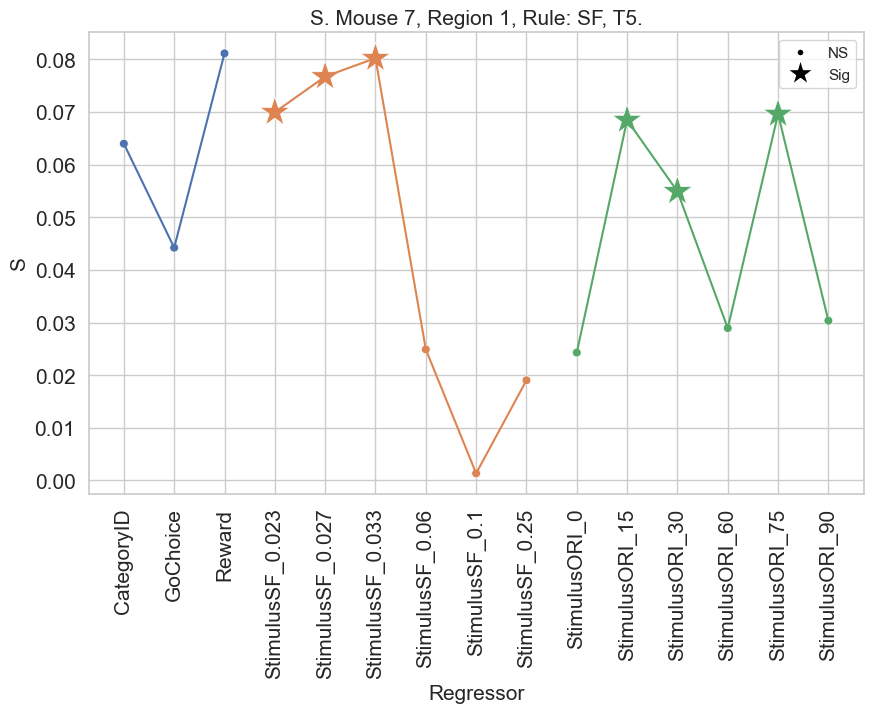

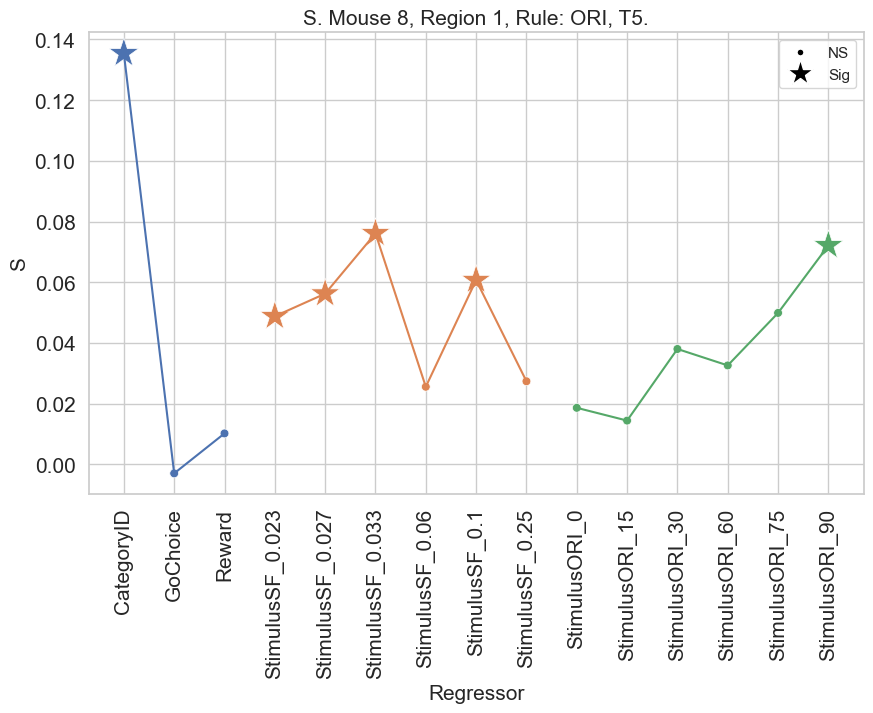

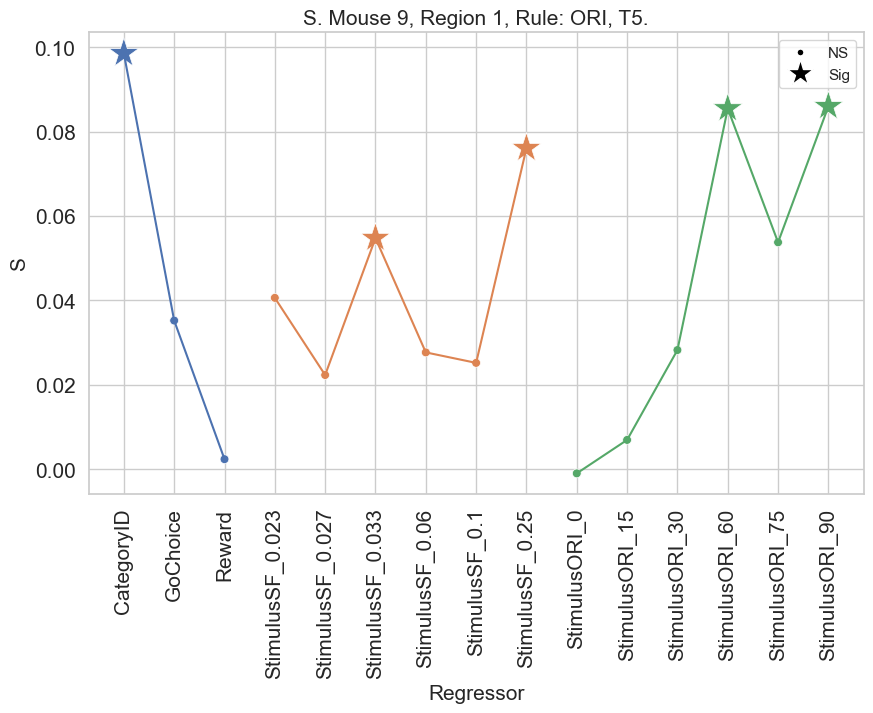

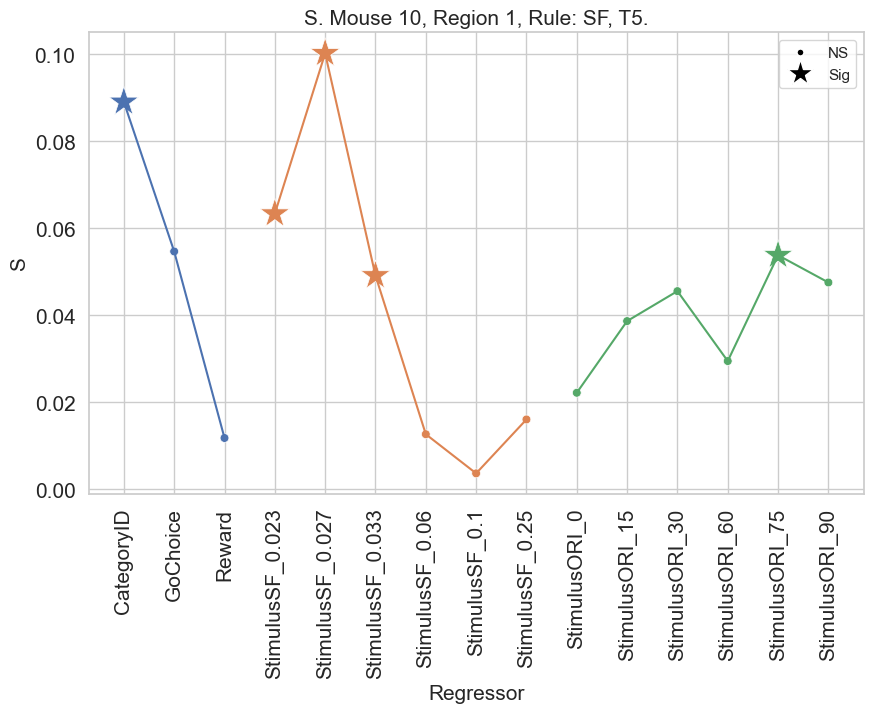

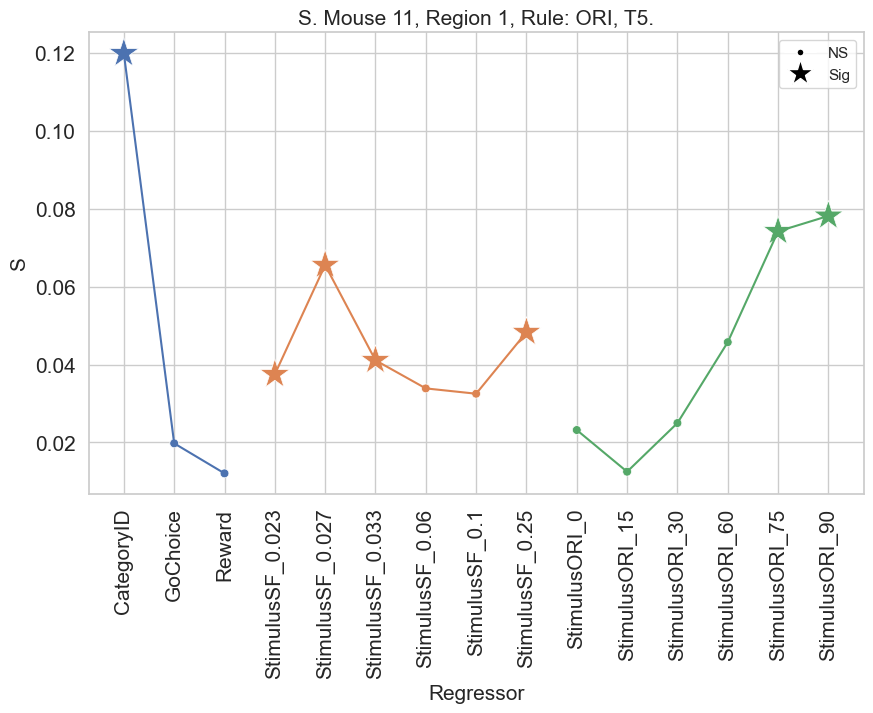

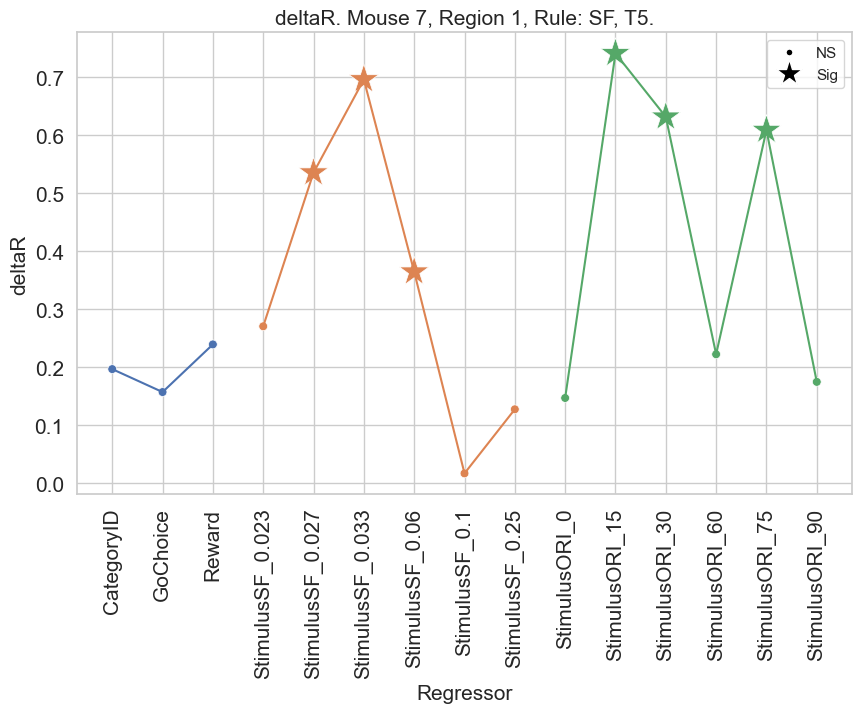

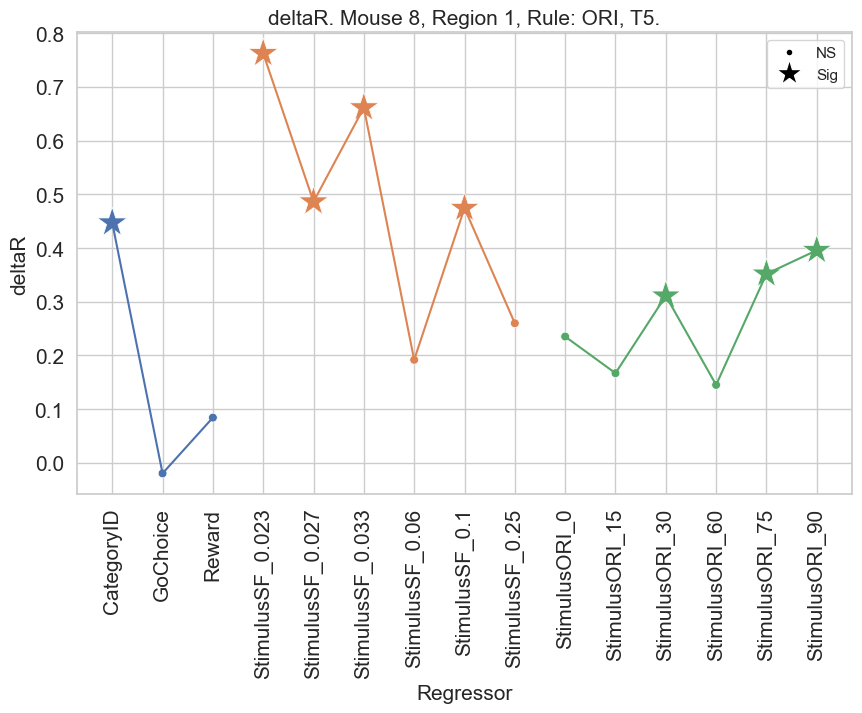

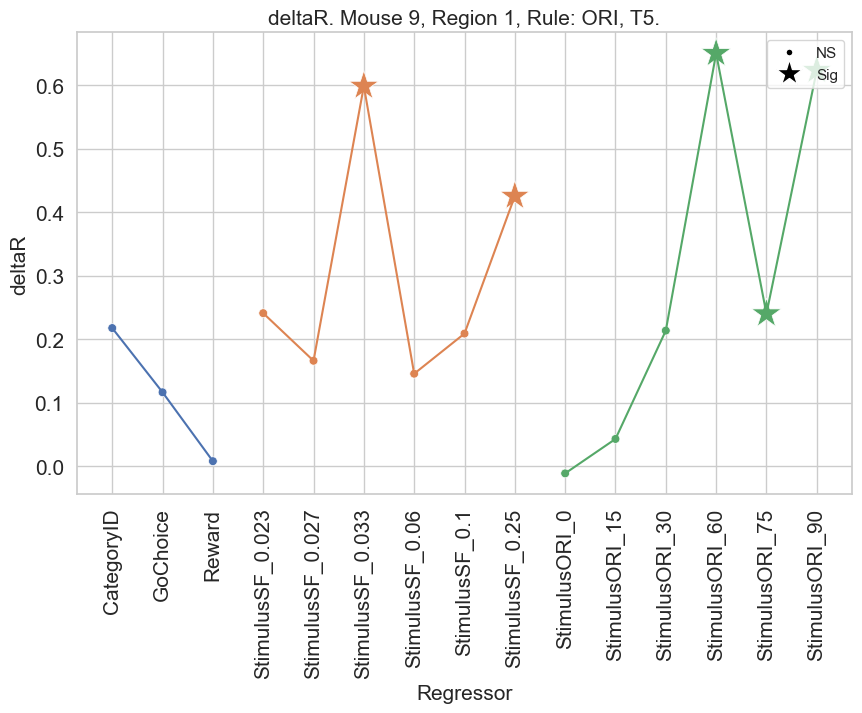

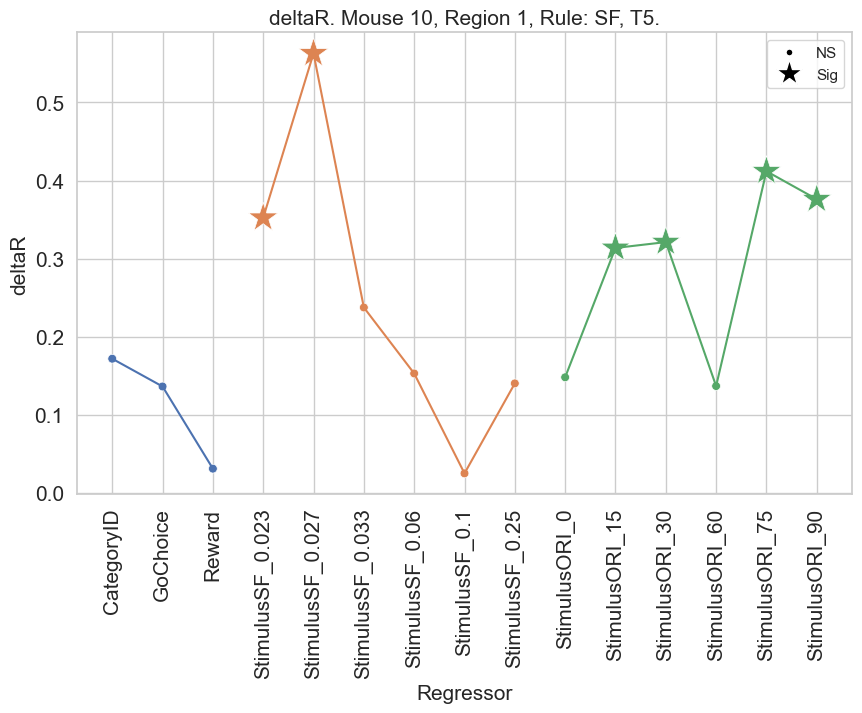

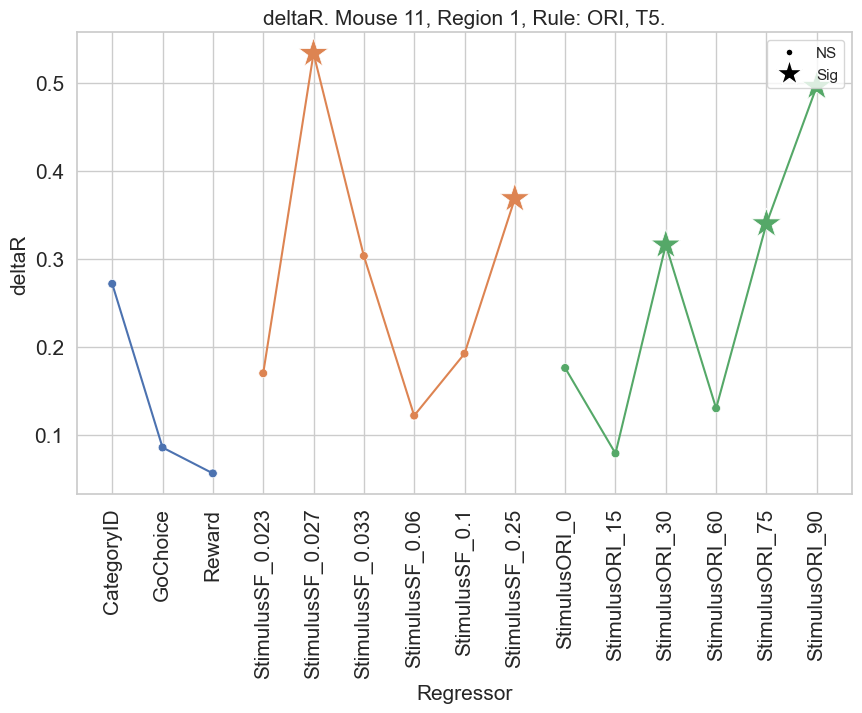

<Figure size 1000x600 with 0 Axes>

In [26]:
# Plot uncorrected mice 7-11, region 1
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(S_mice7_11_region1_T5_fdr[index], "S", mouse, stats = True, region = 1, rule = rules_region[str(mouse)], session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/fdr_corrected/b2b_mice7_11_region1/FDR_")
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(deltaR_mice7_11_region1_T5_fdr[index], "deltaR",  mouse, stats = True, region = 1, rule = rules_region[str(mouse)], session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/fdr_corrected/b2b_mice7_11_region1/FDR_")

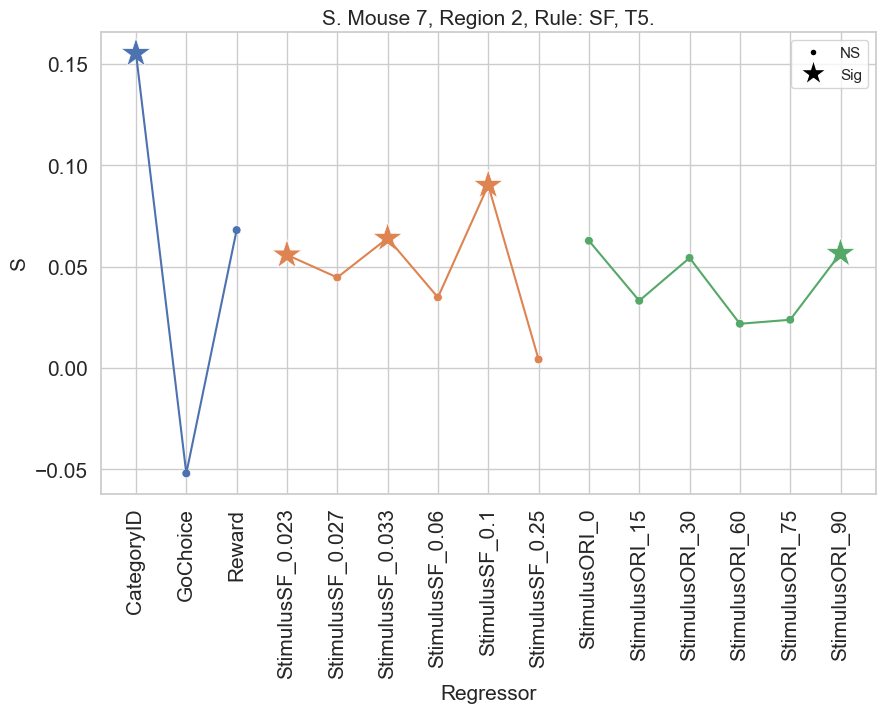

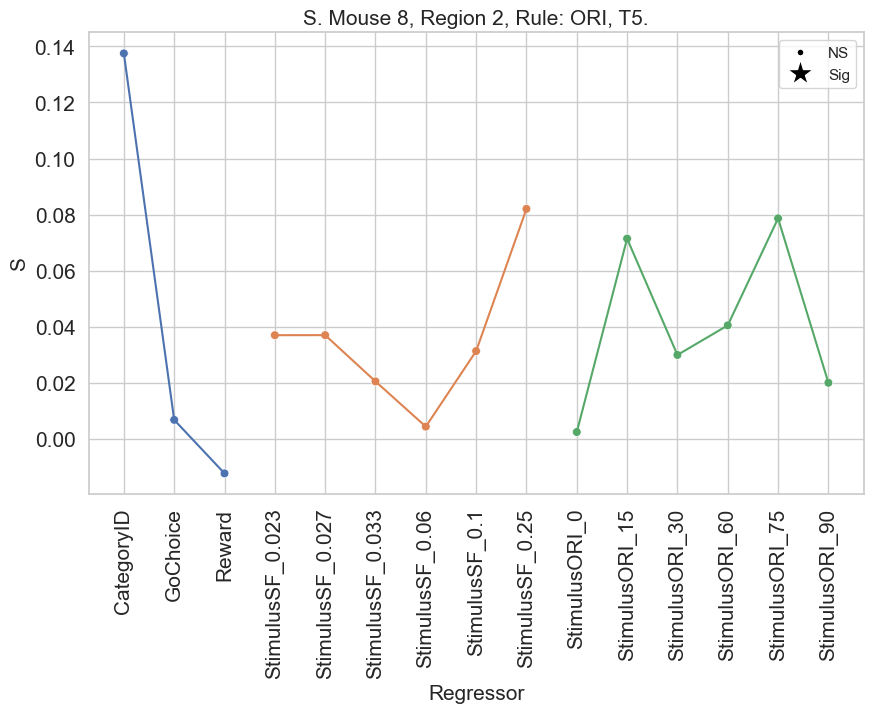

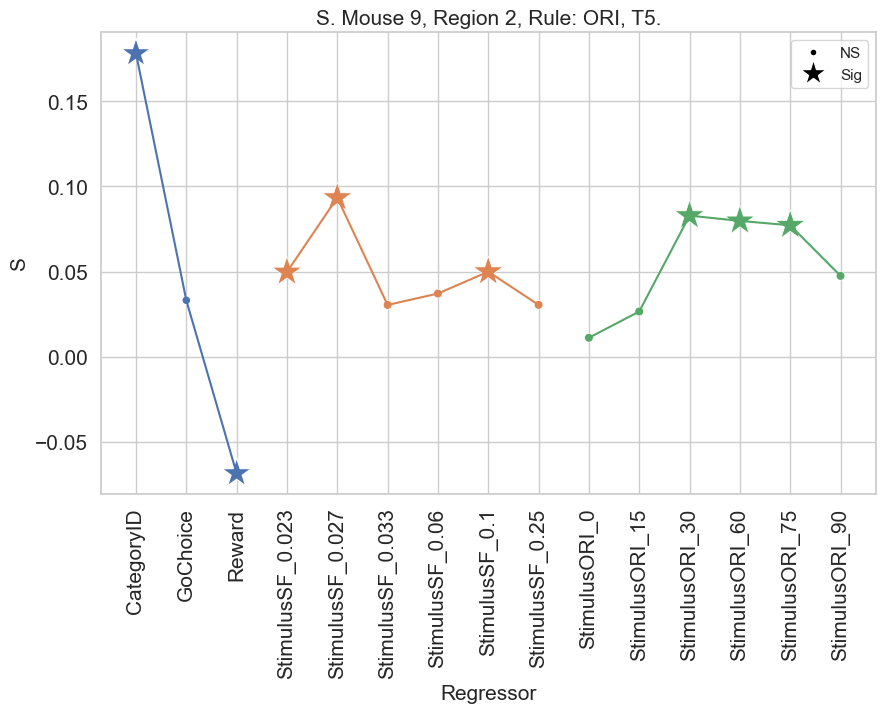

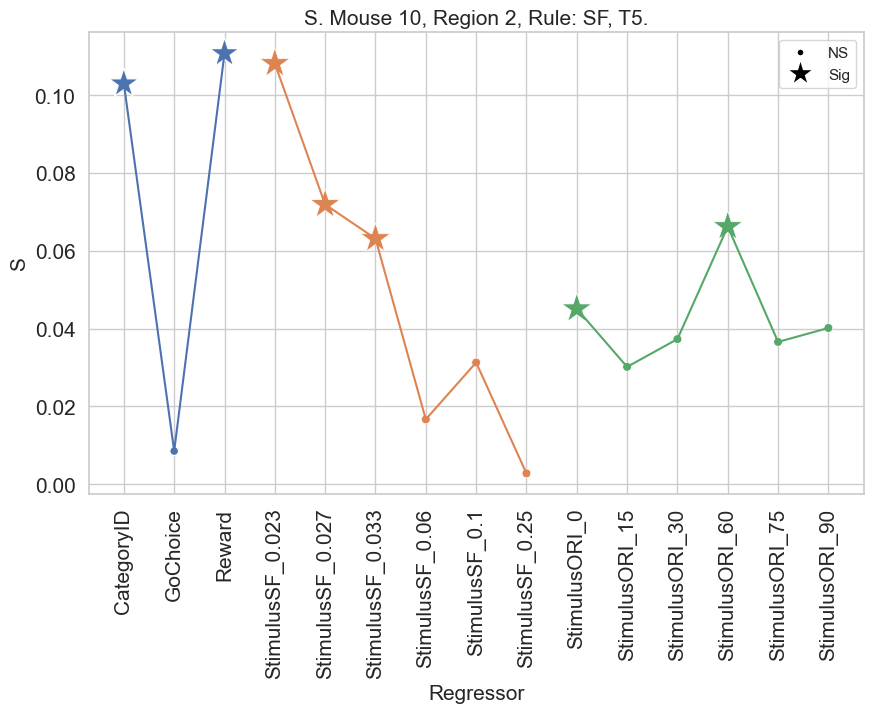

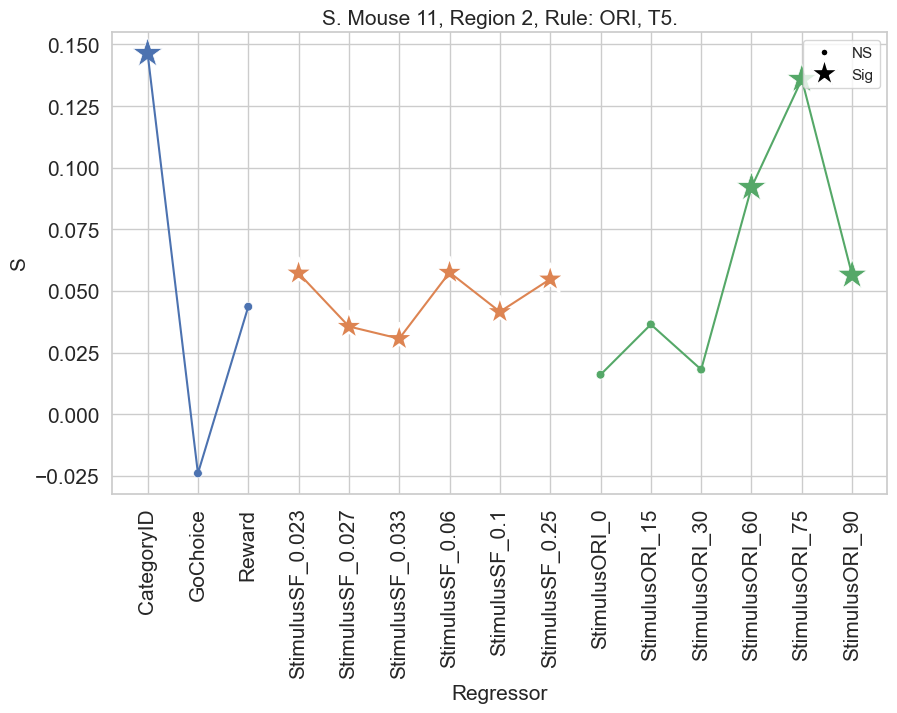

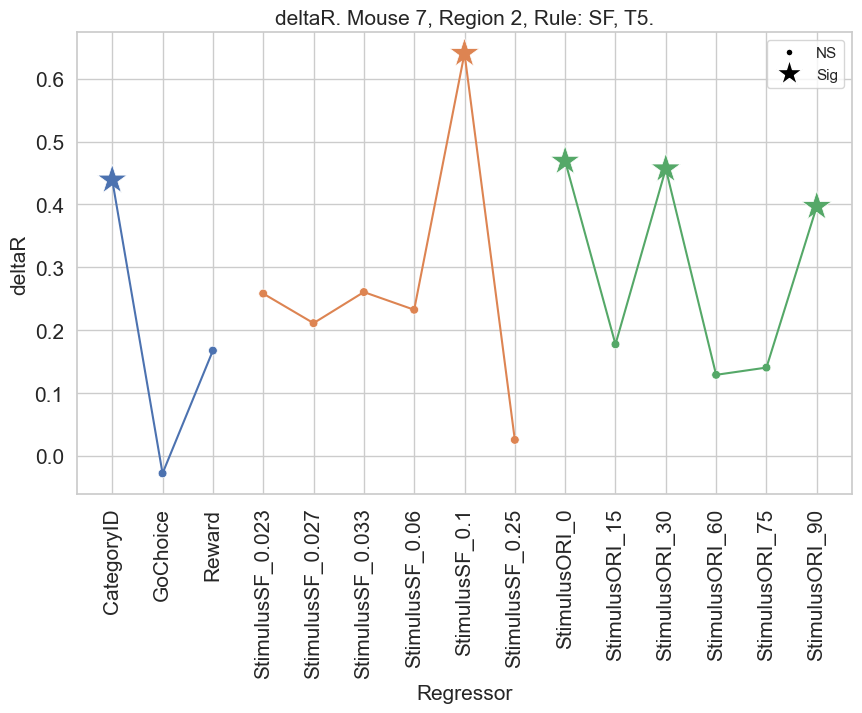

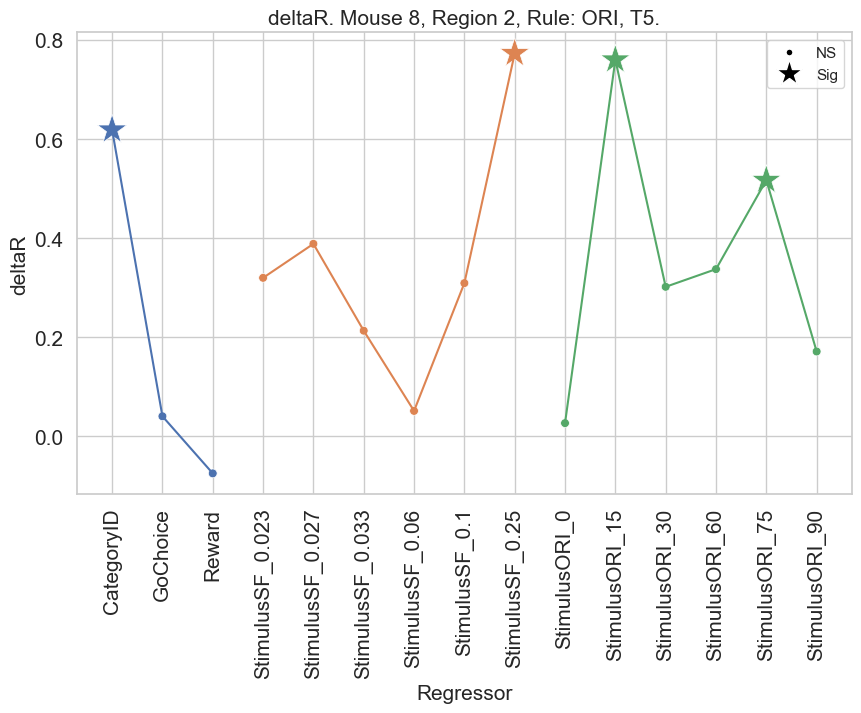

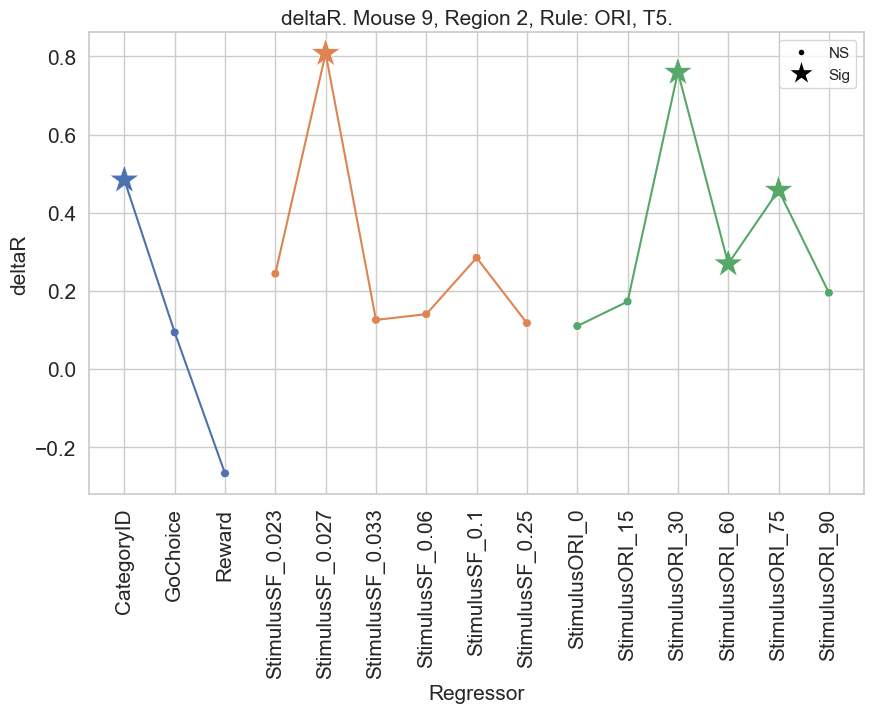

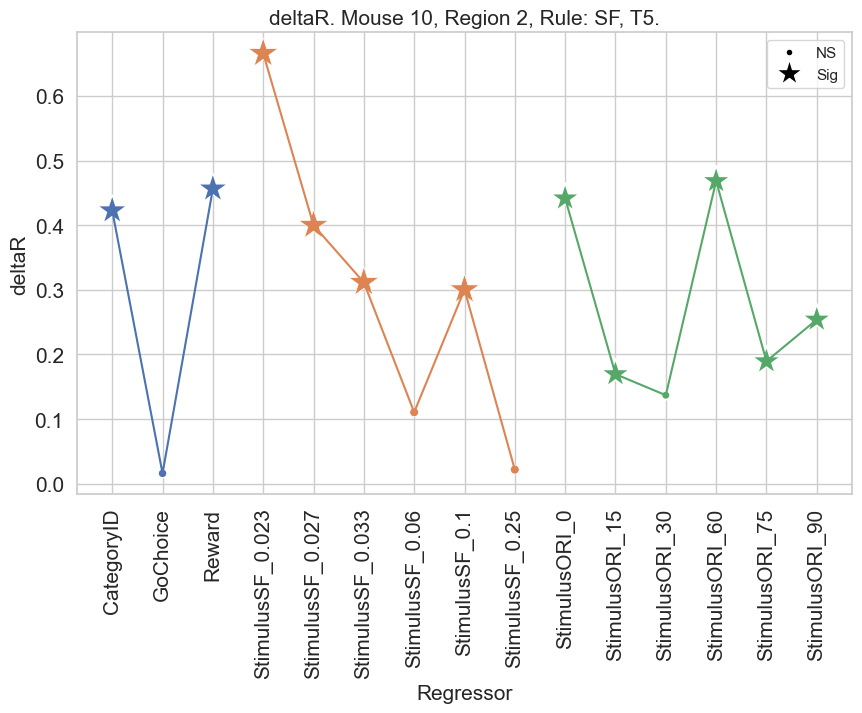

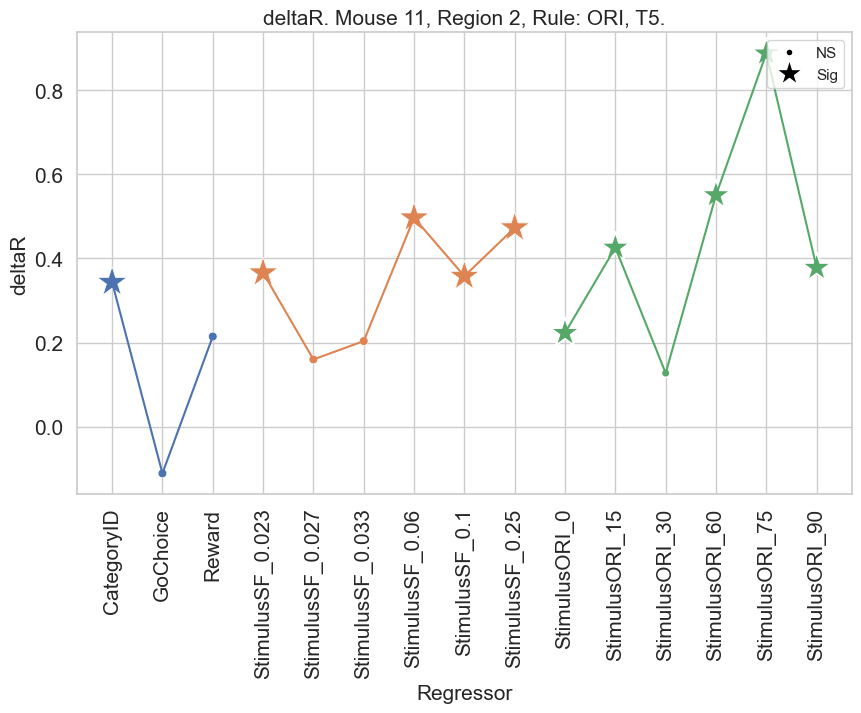

<Figure size 1000x600 with 0 Axes>

In [27]:
# Plot uncorrected mice 7-11, region 2
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(S_mice7_11_region2_T5_fdr[index], "S", mouse, stats = True, region = 2, rule = rules_region[str(mouse)], session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/fdr_corrected/b2b_mice7_11_region2/FDR_")
for index, mouse in enumerate(mice_regions):
    plot_b2b_result(deltaR_mice7_11_region2_T5_fdr[index], "deltaR",  mouse, stats = True, region = 2, rule = rules_region[str(mouse)], session = "T5", save = True, file_dir=os.getcwd() + "/b2b/figures/T5/fdr_corrected/b2b_mice7_11_region2/FDR_")